In [ ]:
# =========================================================
# CÉLULA 0 — Instalações
# =========================================================
!pip -q install yfinance pandas numpy matplotlib ta python-dateutil

In [ ]:
# CÉLULA 1 (SUBSTITUTA) — baixa 2 anos usando period="730d" e interval "60m" (fallback "90m"/"1d")

!pip -q install yfinance pandas numpy python-dateutil

import os, time, math, logging
import numpy as np
import pandas as pd
import yfinance as yf

# silenciar logs barulhentos do yfinance
try:
    yf.utils.get_yf_logger().setLevel(logging.ERROR)
except Exception:
    pass

TICKERS = ["BTC=F", "ETH=F", "GC=F", "EWZ", "USDBRL=X", "SOL-USD"]  # substitutos
DATA_DIR = "/content/data"
os.makedirs(DATA_DIR, exist_ok=True)

INTERVALS_TRY = ["60m", "90m", "1d"]   # tentamos 60m; se falhar, 90m; se nada vier, 1d (para não ficar vazio)
PERIOD = "730d"                        # ~2 anos

def safe_name(tk: str) -> str:
    return tk.replace("^","_").replace("=","").replace("/","_")

def download_intraday_robust(ticker: str) -> pd.DataFrame:
    tk = yf.Ticker(ticker)
    last_err = None
    for itv in INTERVALS_TRY:
        try:
            df = tk.history(period=PERIOD, interval=itv, auto_adjust=False, prepost=True, actions=False)
            if df is not None and not df.empty:
                df = df.copy()
                df.index.name = "datetime_utc"
                # garante colunas
                for c in ["Open","High","Low","Close","Adj Close","Volume"]:
                    if c not in df.columns: df[c] = np.nan
                df = df[["Open","High","Low","Close","Adj Close","Volume"]].sort_index()
                # devolve também o intervalo usado
                df.attrs["used_interval"] = itv
                return df
        except Exception as e:
            last_err = e
        time.sleep(0.3)  # pequeno respiro para evitar rate limit
    # se chegou aqui, falhou tudo
    if last_err:
        print(f"[FAIL] {ticker}: {last_err}")
    return pd.DataFrame()

summary = []
for tk in TICKERS:
    print(f"[DL] {tk} …")
    df = download_intraday_robust(tk)
    if df.empty:
        print(f"[WARN] {tk}: sem dados retornados (nem 1d).")
        summary.append((tk, 0, None, None, None))
        continue

    used_itv = df.attrs.get("used_interval", "60m")
    fn = f"{safe_name(tk)}_{used_itv}_last2y.csv"
    out_path = os.path.join(DATA_DIR, fn)
    df.to_csv(out_path)
    print(f"[OK] {tk}: {len(df)} linhas, intervalo={used_itv} → {out_path}")
    summary.append((tk, len(df), df.index[0], df.index[-1], used_itv))

print("\nResumo:")
for tk, n, a, b, itv in summary:
    print(f" - {tk}: linhas={n}, {a} → {b}, interval={itv}")
print(f"\nArquivos salvos em: {DATA_DIR}")


[DL] BTC=F …
[OK] BTC=F: 13822 linhas, intervalo=60m → /content/data/BTCF_60m_last2y.csv
[DL] ETH=F …
[OK] ETH=F: 13823 linhas, intervalo=60m → /content/data/ETHF_60m_last2y.csv
[DL] GC=F …
[OK] GC=F: 13836 linhas, intervalo=60m → /content/data/GCF_60m_last2y.csv
[DL] EWZ …
[OK] EWZ: 11337 linhas, intervalo=60m → /content/data/EWZ_60m_last2y.csv
[DL] USDBRL=X …
[OK] USDBRL=X: 12128 linhas, intervalo=60m → /content/data/USDBRLX_60m_last2y.csv
[DL] SOL-USD …
[OK] SOL-USD: 17514 linhas, intervalo=60m → /content/data/SOL-USD_60m_last2y.csv

Resumo:
 - BTC=F: linhas=13822, 2023-05-26 00:00:00-04:00 → 2025-10-16 15:00:00-04:00, interval=60m
 - ETH=F: linhas=13823, 2023-05-26 01:00:00-04:00 → 2025-10-16 15:00:00-04:00, interval=60m
 - GC=F: linhas=13836, 2023-05-26 00:00:00-04:00 → 2025-10-16 15:00:00-04:00, interval=60m
 - EWZ: linhas=11337, 2022-11-17 04:00:00-05:00 → 2025-10-16 14:30:00-04:00, interval=60m
 - USDBRL=X: linhas=12128, 2022-12-30 00:00:00+00:00 → 2025-10-16 20:00:00+01:00, in

In [ ]:
# =========================================================
# CÉLULA 2 — Leitura dos CSVs baixados (auto-detecta 60m/90m/1d),
#            coerção numérica de OHLCV e utilitários básicos
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

DATA_DIR = "/content/data"
TICKERS  = ["BTC=F", "ETH=F", "GC=F", "EWZ", "USDBRL=X", "SOL-USD"]  # mantenha igual à Célula 1
PREFERRED_INTERVALS = ["60m", "90m", "1d"]  # ordem de preferência para leitura
NUM_COLS = ["Open","High","Low","Close","Adj Close","Volume"]

def safe_name(tk: str) -> str:
    return tk.replace("^","_").replace("=","").replace("/","_")

def find_csv_for(ticker: str) -> str | None:
    """Procura o arquivo do ticker no DATA_DIR seguindo a ordem 60m→90m→1d."""
    base = safe_name(ticker)
    for itv in PREFERRED_INTERVALS:
        fn = f"{base}_{itv}_last2y.csv"
        path = os.path.join(DATA_DIR, fn)
        if os.path.exists(path) and os.path.getsize(path) > 0:
            return path
    # fallback genérico (se o nome do intervalo for diferente)
    # pega o primeiro arquivo que comece com base_ e termine com _last2y.csv
    for fn in os.listdir(DATA_DIR):
        if fn.startswith(base + "_") and fn.endswith("_last2y.csv"):
            return os.path.join(DATA_DIR, fn)
    return None

def load_price_series(path: str) -> pd.DataFrame:
    """Lê CSV, garante índice datetime e colunas OHLCV numéricas."""
    df = pd.read_csv(path)
    # índice
    if "datetime_utc" in df.columns:
        df["datetime_utc"] = pd.to_datetime(df["datetime_utc"], utc=True, errors="coerce")
        df = df.set_index("datetime_utc")
    else:
        for c in ("Datetime","Date","date"):
            if c in df.columns:
                df[c] = pd.to_datetime(df[c], utc=True, errors="coerce")
                df = df.set_index(c)
                break
    df = df.sort_index()

    # coerção numérica
    for c in NUM_COLS:
        if c not in df.columns:
            df[c] = np.nan
        df[c] = pd.to_numeric(df[c], errors="coerce")

    # limpeza
    df["Volume"] = df["Volume"].fillna(0)
    df = df.dropna(subset=["Close"])
    return df[NUM_COLS]

# ---- Lê todos os ativos
FILES = {tk: find_csv_for(tk) for tk in TICKERS}
missing = {tk: p for tk, p in FILES.items() if p is None}
if missing:
    raise FileNotFoundError(
        "Arquivos não encontrados para: "
        + ", ".join(f"{tk} (procure *_60m/_90m/_1d_last2y.csv)" for tk in missing)
        + f"\nVerifique a Célula 1 (download) e o conteúdo de {DATA_DIR}"
    )

assets = {tk: load_price_series(p) for tk, p in FILES.items()}

# ---- Sanity check
for tk, df in assets.items():
    print(
        f"{tk:9s} → {df.index[0]} → {df.index[-1]} | rows={len(df)} | "
        f"dtypes={{" + ", ".join(f"{k}:{str(v)}" for k,v in df.dtypes.items()) + "}}"
    )

# ---- Utilitários básicos usados nas próximas células
def returns_from_close(df: pd.DataFrame) -> pd.Series:
    return df["Close"].pct_change().fillna(0.0)

def equity_buyhold(close: pd.Series, init_capital: float) -> pd.Series:
    ret = close.pct_change().fillna(0.0)
    return (1.0 + ret).cumprod() * init_capital


BTC=F     → 2023-05-26 04:00:00+00:00 → 2025-10-16 19:00:00+00:00 | rows=13822 | dtypes={Open:float64, High:float64, Low:float64, Close:float64, Adj Close:float64, Volume:int64}}
ETH=F     → 2023-05-26 05:00:00+00:00 → 2025-10-16 19:00:00+00:00 | rows=13823 | dtypes={Open:float64, High:float64, Low:float64, Close:float64, Adj Close:float64, Volume:int64}}
GC=F      → 2023-05-26 04:00:00+00:00 → 2025-10-16 19:00:00+00:00 | rows=13836 | dtypes={Open:float64, High:float64, Low:float64, Close:float64, Adj Close:float64, Volume:int64}}
EWZ       → 2022-11-17 09:00:00+00:00 → 2025-10-16 18:30:00+00:00 | rows=11337 | dtypes={Open:float64, High:float64, Low:float64, Close:float64, Adj Close:float64, Volume:int64}}
USDBRL=X  → 2022-12-30 00:00:00+00:00 → 2025-10-16 19:00:00+00:00 | rows=12128 | dtypes={Open:float64, High:float64, Low:float64, Close:float64, Adj Close:float64, Volume:int64}}
SOL-USD   → 2023-10-18 00:00:00+00:00 → 2025-10-16 19:19:00+00:00 | rows=17514 | dtypes={Open:float64, Hi

In [ ]:
# =========================================================
# CÉLULA 3 — Estratégias e métricas (com perf_stats corrigida)
# =========================================================
from ta.momentum import RSIIndicator
from ta.volatility import AverageTrueRange
import math

def rolling_vwap(df: pd.DataFrame, window: int = 24) -> pd.Series:
    tp = (df["High"] + df["Low"] + df["Close"]) / 3.0
    vol = df["Volume"].replace(0, np.nan)
    vwap = (tp * vol).rolling(window, min_periods=1).sum() / vol.rolling(window, min_periods=1).sum()
    return vwap.fillna(method="bfill").fillna(method="ffill")

# 1) Donchian
def strat_donchian(df: pd.DataFrame, n: int = 24) -> pd.Series:
    hh = df["High"].rolling(n).max()
    ll = df["Low"].rolling(n).min()
    sig = pd.Series(0.0, index=df.index)
    sig = np.where(df["Close"] > hh.shift(1), 1, sig)
    sig = np.where(df["Close"] < ll.shift(1), -1, sig)
    return pd.Series(sig, index=df.index).replace(0, np.nan).ffill().fillna(0)

# 2) EMA cross
def strat_ema_cross(df: pd.DataFrame, fast: int = 20, slow: int = 50) -> pd.Series:
    ema_f = df["Close"].ewm(span=fast, adjust=False).mean()
    ema_s = df["Close"].ewm(span=slow, adjust=False).mean()
    sig = pd.Series(0.0, index=df.index)
    sig[(ema_f > ema_s) & (ema_f.shift(1) <= ema_s.shift(1))] = 1
    sig[(ema_f < ema_s) & (ema_f.shift(1) >= ema_s.shift(1))] = -1
    return sig.replace(0, np.nan).ffill().fillna(0)

# 3) VWAP-revert (z-score)
def strat_vwap_revert(df: pd.DataFrame, win: int = 24, z_entry: float = 1.0) -> pd.Series:
    vwap = rolling_vwap(df, window=win)
    spread = df["Close"] - vwap
    z = (spread - spread.rolling(win).mean()) / (spread.rolling(win).std() + 1e-9)
    sig = pd.Series(0.0, index=df.index)
    sig[z <= -z_entry] = 1
    sig[z >=  z_entry] = -1
    return sig.replace(0, np.nan).ffill().fillna(0)

# 4) RSI reversal
def strat_rsi_reversal(df: pd.DataFrame, rsi_len: int = 14, lo: int = 30, hi: int = 70) -> pd.Series:
    rsi = RSIIndicator(close=df["Close"], window=rsi_len).rsi()
    sig = pd.Series(0.0, index=df.index)
    sig[rsi < lo] = 1
    sig[rsi > hi] = -1
    sig = sig.replace(0, np.nan).ffill().fillna(0)
    # sair no cruzamento de 50
    exit_long  = (rsi.shift(1) < 50) & (rsi >= 50)
    exit_short = (rsi.shift(1) > 50) & (rsi <= 50)
    sig[exit_long]  = 0
    sig[exit_short] = 0
    return sig.replace(0, np.nan).ffill().fillna(0)

# 5) ATR breakout
def strat_atr_breakout(df: pd.DataFrame, atr_len: int = 14, k: float = 0.75) -> pd.Series:
    atr = AverageTrueRange(high=df["High"], low=df["Low"], close=df["Close"], window=atr_len).average_true_range()
    up = df["Close"].shift(1) + k*atr.shift(1)
    dn = df["Close"].shift(1) - k*atr.shift(1)
    sig = pd.Series(0.0, index=df.index)
    sig[df["Close"] > up] = 1
    sig[df["Close"] < dn] = -1
    return sig.replace(0, np.nan).ffill().fillna(0)

STRATS = {
    "Donchian24": strat_donchian,
    "EMAcross(20,50)": strat_ema_cross,
    "VWAP-Revert": strat_vwap_revert,
    "RSI(14)Rev": strat_rsi_reversal,
    "ATR-BO(14,0.75)": strat_atr_breakout,
}

def signal_to_equity(close: pd.Series, ret: pd.Series, sig: pd.Series,
                     init_capital: float, cost_bp: float = 0.0) -> pd.DataFrame:
    sig = sig.reindex(ret.index).fillna(0)
    turns = sig.diff().abs().fillna(0)               # mudança de posição
    cost = (cost_bp / 10000.0) * turns               # ida+volta em bps
    strat_ret = sig.shift(1).fillna(0) * ret - cost
    equity = (1.0 + strat_ret).cumprod() * init_capital
    return pd.DataFrame({"Close": close, "ret": ret, "sig": sig,
                         "strat_ret": strat_ret, "equity": equity})

def max_drawdown(series: pd.Series):
    rollmax = series.cummax()
    dd = series/rollmax - 1.0
    end = dd.idxmin()
    start = (series.loc[:end]).idxmax()
    return dd.min(), start, end

# *** perf_stats robusto (não depende do índice ser datetime) ***
def perf_stats(equity: pd.Series, ret: pd.Series, trades_sig: pd.Series, periods_per_year: float):
    n = max(len(equity), 1)
    growth = float(equity.iloc[-1]) / float(equity.iloc[0])
    cagr = (growth ** (periods_per_year / n) - 1.0) if n > 1 else np.nan

    mu = ret.mean() * periods_per_year
    sd = ret.std(ddof=0) * math.sqrt(periods_per_year)
    sharpe = mu / sd if sd > 0 else np.nan

    mdd, _, _ = max_drawdown(equity)
    mar = (cagr / abs(mdd)) if (mdd is not None and mdd < 0) else np.nan

    pos = ret[ret > 0].sum()
    neg = -ret[ret < 0].sum()
    pf = (pos/neg) if neg > 0 else np.nan

    n_trades = int(trades_sig.diff().abs().fillna(0).sum())
    wins = losses = 0
    if n_trades > 0:
        seg = (trades_sig != trades_sig.shift(1)).cumsum()
        g = ret.groupby(seg).sum()
        wins = int((g > 0).sum()); losses = int((g <= 0).sum())
    winrate = wins / (wins + losses) if (wins + losses) > 0 else np.nan

    return {"CAGR": cagr, "Sharpe": sharpe, "MaxDD": mdd, "MAR": mar,
            "ProfitFactor": pf, "WinRate": winrate, "Trades": n_trades}

/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


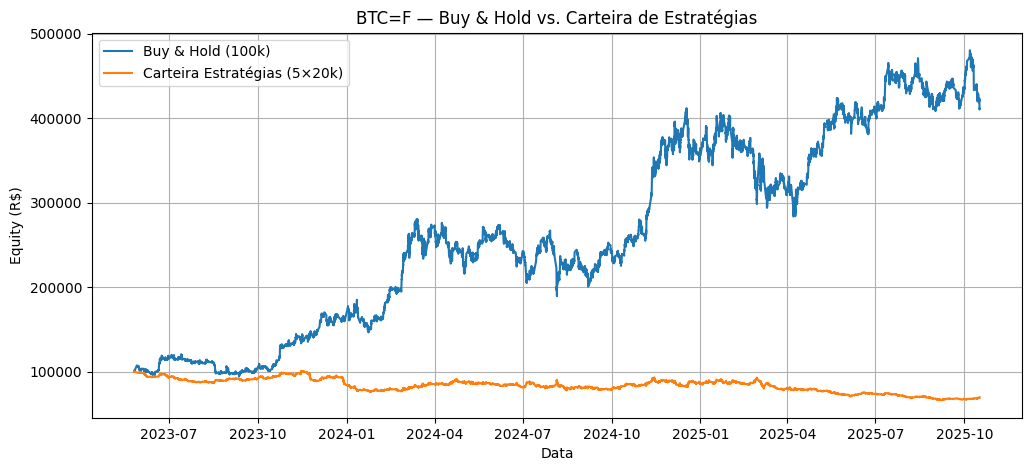


==== Estatísticas — BTC=F (estratégias individuais; capital 20,000 cada) ====


,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
"ATR-BO(14,0.75)",-4.02%,0.23,-59.70%,-0.07,1.01,36.95%,2833
RSI(14)Rev,-10.76%,0.11,-53.22%,-0.20,1.00,56.76%,219
"EMAcross(20,50)",-22.33%,-0.12,-59.08%,-0.38,1.00,28.86%,593
Donchian24,-31.97%,-0.34,-66.33%,-0.48,0.99,34.00%,497
VWAP-Revert,-35.78%,-0.44,-58.48%,-0.61,0.99,58.78%,1409


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


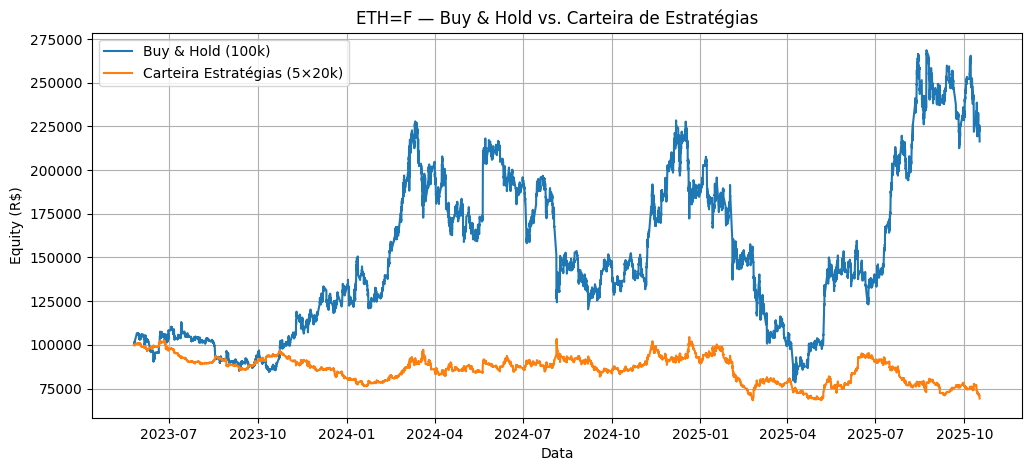


==== Estatísticas — ETH=F (estratégias individuais; capital 20,000 cada) ====


,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
"ATR-BO(14,0.75)",12.03%,0.54,-45.55%,0.26,1.02,36.59%,2823
RSI(14)Rev,-17.39%,0.16,-51.49%,-0.34,1.01,64.23%,243
"EMAcross(20,50)",-22.41%,0.08,-78.98%,-0.28,1.00,30.48%,581
Donchian24,-33.90%,-0.12,-69.81%,-0.49,1.00,32.06%,521
VWAP-Revert,-49.69%,-0.47,-72.97%,-0.68,0.98,57.56%,1425


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


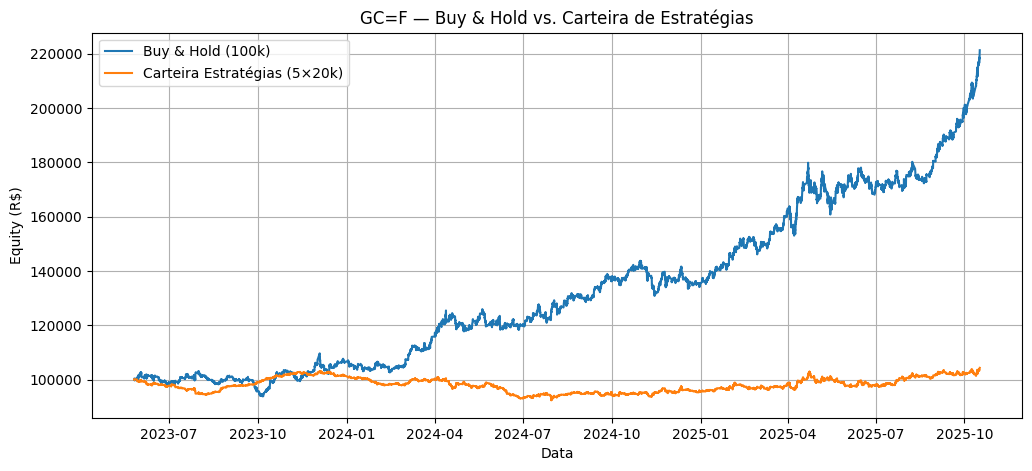


==== Estatísticas — GC=F (estratégias individuais; capital 20,000 cada) ====


,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
"EMAcross(20,50)",30.45%,1.50,-15.64%,1.95,1.05,32.14%,501
Donchian24,11.03%,0.65,-18.62%,0.59,1.02,40.48%,417
"ATR-BO(14,0.75)",8.36%,0.52,-15.81%,0.53,1.02,35.60%,2345
VWAP-Revert,-19.78%,-1.07,-43.22%,-0.46,0.97,58.97%,1401
RSI(14)Rev,-22.05%,-1.22,-37.16%,-0.59,0.96,58.33%,213


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


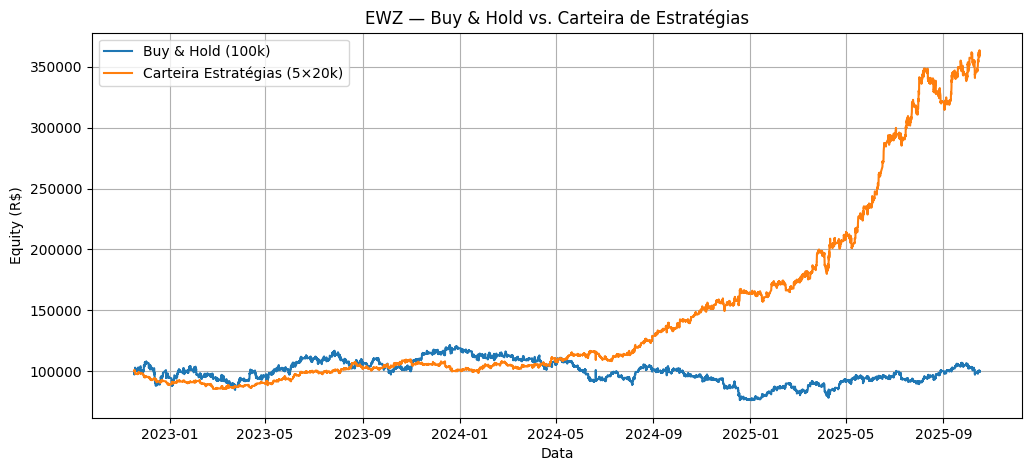


==== Estatísticas — EWZ (estratégias individuais; capital 20,000 cada) ====


,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
VWAP-Revert,773.91%,4.74,-21.40%,36.17,1.17,66.47%,1333
RSI(14)Rev,0.74%,0.25,-33.13%,0.02,1.01,54.55%,151
"EMAcross(20,50)",-62.01%,-1.75,-73.36%,-0.85,0.94,27.39%,479
Donchian24,-76.87%,-2.81,-86.27%,-0.89,0.91,27.75%,451
"ATR-BO(14,0.75)",-96.71%,-6.82,-98.90%,-0.98,0.79,28.50%,2965


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


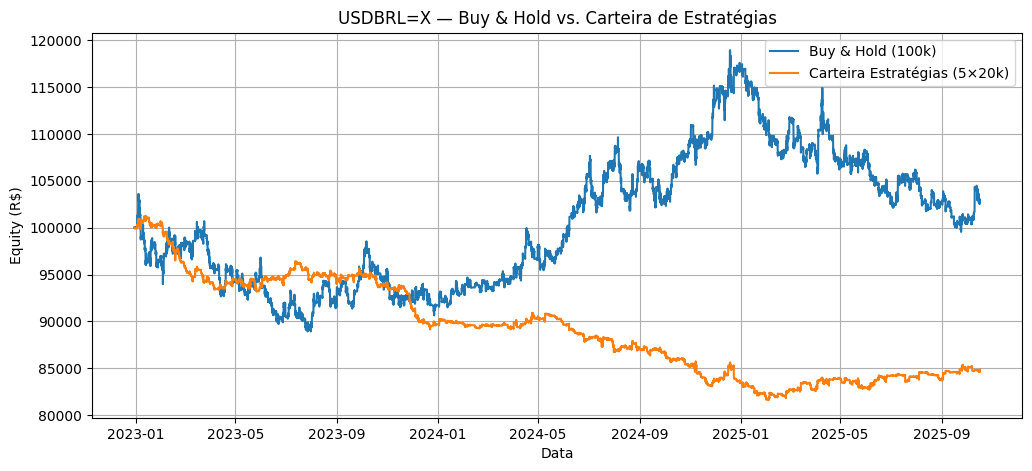


==== Estatísticas — USDBRL=X (estratégias individuais; capital 20,000 cada) ====


,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
RSI(14)Rev,32.38%,1.51,-17.88%,1.81,1.05,69.49%,233
VWAP-Revert,0.00%,nan,0.00%,nan,nan,nan%,0
"EMAcross(20,50)",-13.75%,-0.65,-25.11%,-0.55,0.98,28.40%,483
Donchian24,-13.94%,-0.66,-26.83%,-0.52,0.98,34.98%,443
"ATR-BO(14,0.75)",-77.10%,-7.35,-87.30%,-0.88,0.77,27.00%,3789


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


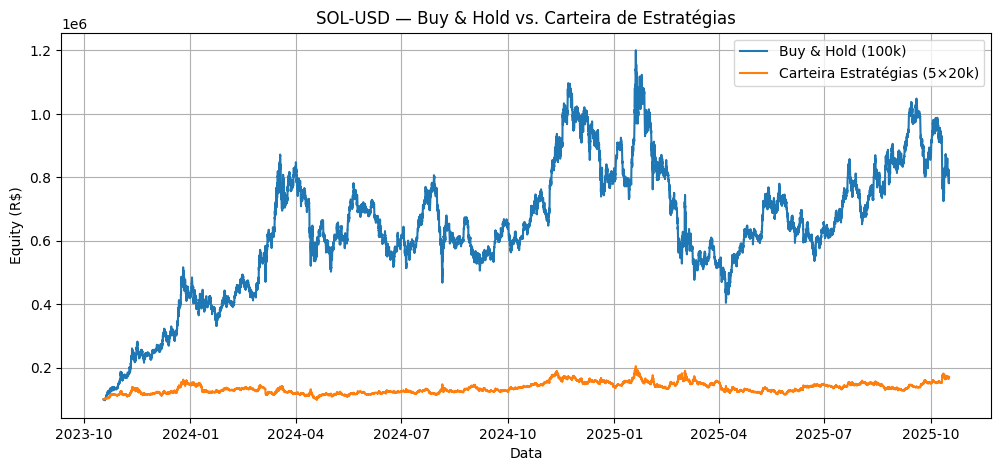


==== Estatísticas — SOL-USD (estratégias individuais; capital 20,000 cada) ====


,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
"EMAcross(20,50)",100.49%,1.21,-50.96%,1.97,1.04,37.99%,613
Donchian24,71.14%,1.04,-59.29%,1.20,1.03,39.94%,713
"ATR-BO(14,0.75)",6.73%,0.54,-67.85%,0.10,1.02,38.46%,5119
RSI(14)Rev,-52.87%,-0.34,-81.30%,-0.65,0.99,58.59%,253
VWAP-Revert,-53.91%,-0.36,-87.78%,-0.61,0.99,59.66%,1881


In [ ]:
# =========================================================
# CÉLULA 4 — Simulação (100k por ativo; divide igualmente entre as 5 estratégias)
# =========================================================
INIT_PER_ASSET = 100_000.0
COST_BP = 0.0                   # custos (ida+volta) em basis points. 0 por padrão.
PPY = 24*365                    # 1h ≈ 8760/ano

all_stats = {}

for tk, df in assets.items():
    close = df["Close"].copy()
    ret = returns_from_close(df)
    bh = equity_buyhold(close, INIT_PER_ASSET)

    per_strat_cap = INIT_PER_ASSET / len(STRATS)
    strat_equities = []
    stats_rows = []

    for name, fn in STRATS.items():
        sig = fn(df)
        res = signal_to_equity(close, ret, sig, per_strat_cap, cost_bp=COST_BP)
        strat_equities.append(res["equity"])
        st = perf_stats(res["equity"], res["strat_ret"], res["sig"], periods_per_year=PPY)
        st["Strategy"] = name
        stats_rows.append(st)

    # carteira = soma das curvas (cada uma começou com 20k)
    strat_port = pd.concat(strat_equities, axis=1).sum(axis=1)

    # gráfico
    plt.figure()
    plt.plot(bh.index, bh.values, label="Buy & Hold (100k)")
    plt.plot(strat_port.index, strat_port.values, label="Carteira Estratégias (5×20k)")
    plt.title(f"{tk} — Buy & Hold vs. Carteira de Estratégias")
    plt.xlabel("Data")
    plt.ylabel("Equity (R$)")
    plt.legend()
    plt.show()

    stats_df = pd.DataFrame(stats_rows).set_index("Strategy")
    all_stats[tk] = stats_df.sort_values("CAGR", ascending=False)
    print(f"\n==== Estatísticas — {tk} (estratégias individuais; capital {per_strat_cap:,.0f} cada) ====")
    display(all_stats[tk].style.format({
        "CAGR": "{:.2%}", "Sharpe": "{:.2f}", "MaxDD": "{:.2%}", "MAR": "{:.2f}",
        "ProfitFactor": "{:.2f}", "WinRate": "{:.2%}", "Trades": "{:.0f}"
    }))



In [ ]:
# =========================================================
# CÉLULA 5 — Export: estatísticas e curvas por ativo
# =========================================================
OUT_DIR = "/content/output"
os.makedirs(OUT_DIR, exist_ok=True)

# salva estatísticas
for tk, sdf in all_stats.items():
    path = os.path.join(OUT_DIR, f"{tk.replace('=','').replace('^','_').replace('/','_')}_strategy_stats.csv")
    sdf.to_csv(path)
    print("[OK] Export stats:", path)

# salva curvas buy&hold e por estratégia
for tk, df in assets.items():
    close = df["Close"]
    ret = returns_from_close(df)
    bh = equity_buyhold(close, INIT_PER_ASSET)
    per_strat_cap = INIT_PER_ASSET / len(STRATS)
    curves = {"BuyHold": bh}
    for name, fn in STRATS.items():
        sig = fn(df)
        res = signal_to_equity(close, ret, sig, per_strat_cap, cost_bp=COST_BP)
        curves[name] = res["equity"]
    curves_df = pd.concat(curves, axis=1)
    path = os.path.join(OUT_DIR, f"{tk.replace('=','').replace('^','_').replace('/','_')}_equity_curves.csv")
    curves_df.to_csv(path)
    print("[OK] Export curves:", path)

print("\nArquivos exportados em:", OUT_DIR)

[OK] Export stats: /content/output/BTCF_strategy_stats.csv
[OK] Export stats: /content/output/ETHF_strategy_stats.csv
[OK] Export stats: /content/output/GCF_strategy_stats.csv
[OK] Export stats: /content/output/EWZ_strategy_stats.csv
[OK] Export stats: /content/output/USDBRLX_strategy_stats.csv
[OK] Export stats: /content/output/SOL-USD_strategy_stats.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export curves: /content/output/BTCF_equity_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export curves: /content/output/ETHF_equity_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export curves: /content/output/GCF_equity_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export curves: /content/output/EWZ_equity_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export curves: /content/output/USDBRLX_equity_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export curves: /content/output/SOL-USD_equity_curves.csv

Arquivos exportados em: /content/output


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


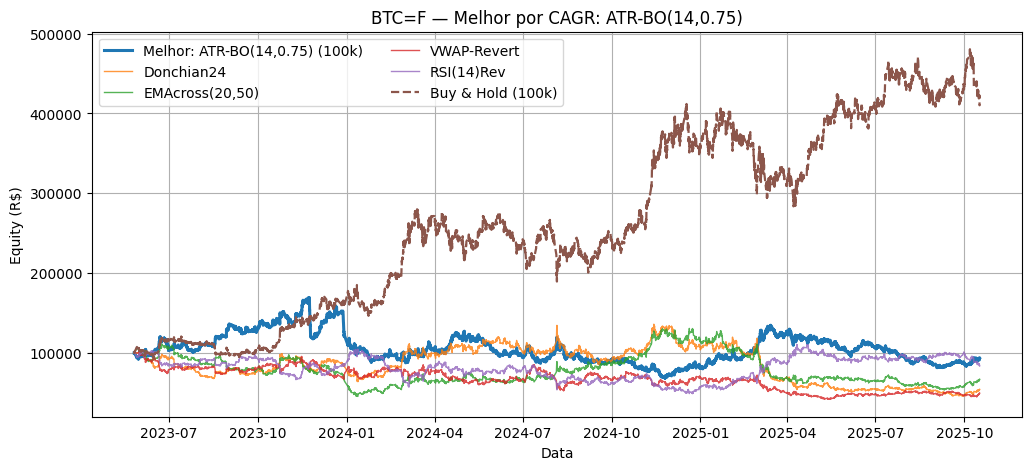

[OK] BTC=F: Melhor por CAGR = ATR-BO(14,0.75)
[OK] Export: /content/output/BTCF_best_vs_all_stats.csv
[OK] Export: /content/output/BTCF_best_vs_all_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


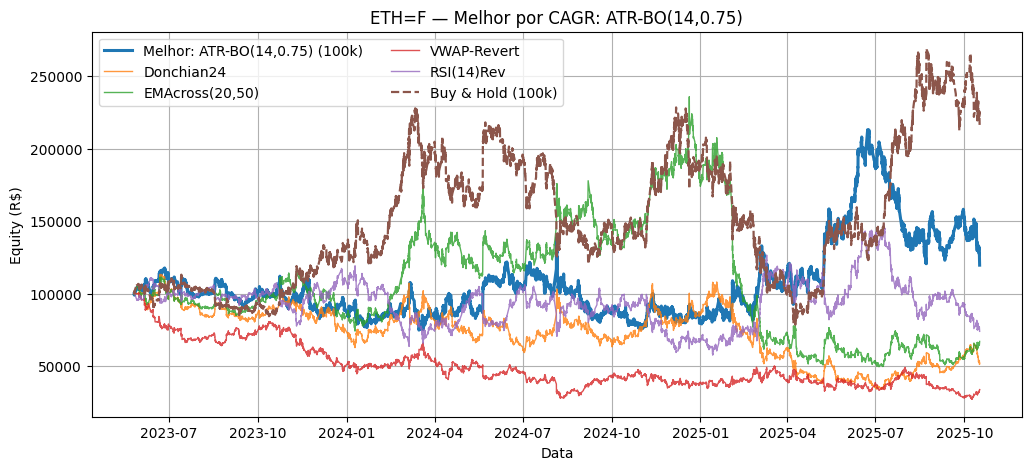

[OK] ETH=F: Melhor por CAGR = ATR-BO(14,0.75)
[OK] Export: /content/output/ETHF_best_vs_all_stats.csv
[OK] Export: /content/output/ETHF_best_vs_all_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


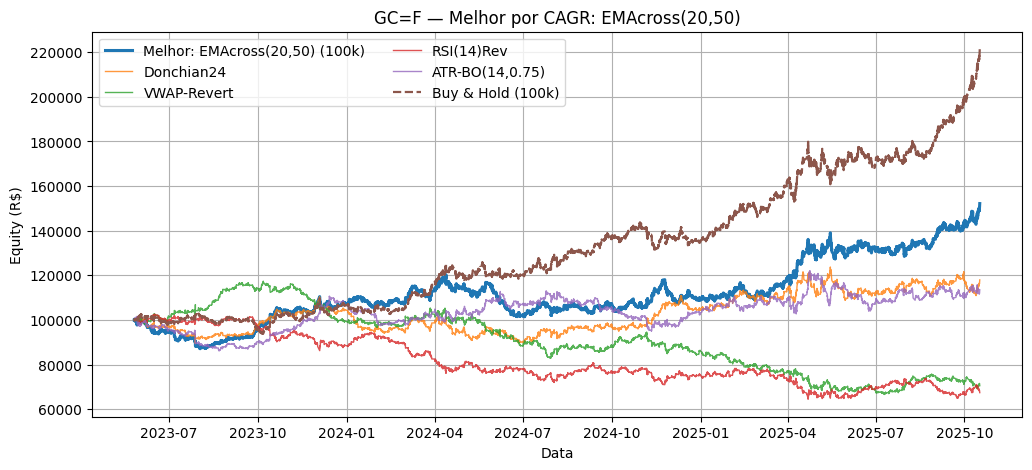

[OK] GC=F: Melhor por CAGR = EMAcross(20,50)
[OK] Export: /content/output/GCF_best_vs_all_stats.csv
[OK] Export: /content/output/GCF_best_vs_all_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


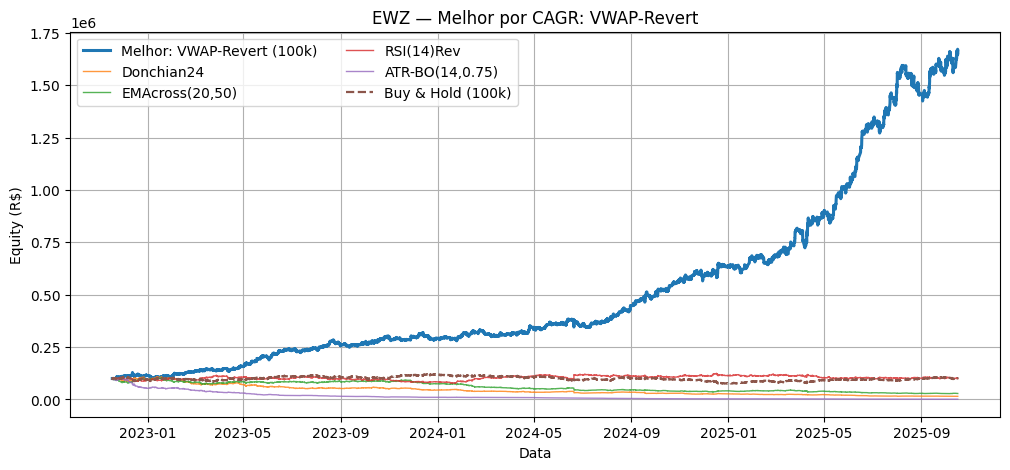

[OK] EWZ: Melhor por CAGR = VWAP-Revert
[OK] Export: /content/output/EWZ_best_vs_all_stats.csv
[OK] Export: /content/output/EWZ_best_vs_all_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


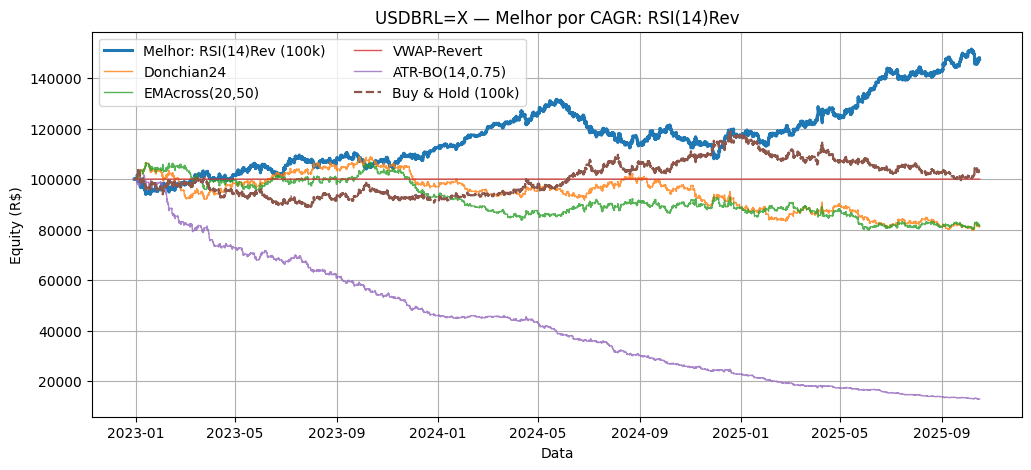

[OK] USDBRL=X: Melhor por CAGR = RSI(14)Rev
[OK] Export: /content/output/USDBRLX_best_vs_all_stats.csv
[OK] Export: /content/output/USDBRLX_best_vs_all_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


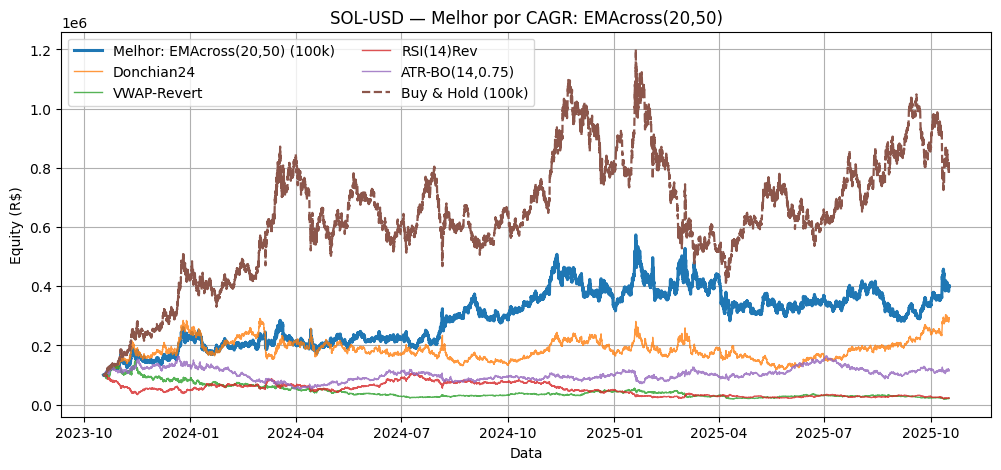

[OK] SOL-USD: Melhor por CAGR = EMAcross(20,50)
[OK] Export: /content/output/SOL-USD_best_vs_all_stats.csv
[OK] Export: /content/output/SOL-USD_best_vs_all_curves.csv

==== Melhor estratégia por ativo ====
 - BTC=F: ATR-BO(14,0.75)  (CAGR = -4.02% )
 - ETH=F: ATR-BO(14,0.75)  (CAGR = 12.03% )
 - GC=F: EMAcross(20,50)  (CAGR = 30.45% )
 - EWZ: VWAP-Revert  (CAGR = 773.91% )
 - USDBRL=X: RSI(14)Rev  (CAGR = 32.38% )
 - SOL-USD: EMAcross(20,50)  (CAGR = 100.49% )

Arquivos exportados em: /content/output


In [ ]:
# =========================================================
# CÉLULA — “A Melhor” estratégia por ATIVO
#           • escolhe a melhor (por métrica) entre as 5
#           • compara a curva dessa MELHOR (100k) com TODAS as outras (100k cada) + Buy&Hold
#           • exporta estatísticas completas e curvas
# =========================================================
# Pré: assets, STRATS, signal_to_equity, perf_stats, returns_from_close,
#      equity_buyhold, INIT_PER_ASSET, COST_BP, PPY definidos.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

RANK_METRIC = "CAGR"     # escolha: "CAGR", "MAR" ou "Sharpe"
OUT_DIR = "/content/output"
os.makedirs(OUT_DIR, exist_ok=True)

best_summary = {}        # guarda a melhor por ativo
full_rankings = {}       # ranking completo por ativo

for tk, df in assets.items():
    close = df["Close"].copy()
    ret   = returns_from_close(df)
    bh    = equity_buyhold(close, INIT_PER_ASSET)

    # --- calcula equity e stats de CADA estratégia usando TODO o capital (100k) ---
    indiv_eq = {}
    rows = []

    for name, fn in STRATS.items():
        sig = fn(df)
        res = signal_to_equity(close, ret, sig, INIT_PER_ASSET, cost_bp=COST_BP)
        indiv_eq[name] = res["equity"]
        st = perf_stats(res["equity"], res["strat_ret"], res["sig"], periods_per_year=PPY)
        st["Strategy"] = name
        rows.append(st)

    rank_df = pd.DataFrame(rows).set_index("Strategy").sort_values(RANK_METRIC, ascending=False)
    full_rankings[tk] = rank_df
    best_name = rank_df.index[0]
    best_summary[tk] = (best_name, rank_df.loc[best_name, RANK_METRIC])

    # --- gráfico: Buy&Hold + Melhor (100k) vs Outras (100k) ---
    plt.figure()
    # melhor: linha mais destacada
    plt.plot(indiv_eq[best_name].index, indiv_eq[best_name].values, label=f"Melhor: {best_name} (100k)", linewidth=2.2)
    # outras: linhas mais finas
    for name, eq in indiv_eq.items():
        if name == best_name:
            continue
        plt.plot(eq.index, eq.values, label=name, linewidth=1.0, alpha=0.8)
    # buy&hold
    plt.plot(bh.index, bh.values, label="Buy & Hold (100k)", linewidth=1.6, linestyle="--")

    plt.title(f"{tk} — Melhor por {RANK_METRIC}: {best_name}")
    plt.xlabel("Data"); plt.ylabel("Equity (R$)")
    plt.legend(ncol=2)
    plt.show()

    # --- prints/exports ---
    base = tk.replace('=','').replace('^','_').replace('/','_')
    # ranking completo
    rank_path = os.path.join(OUT_DIR, f"{base}_best_vs_all_stats.csv")
    rank_df.to_csv(rank_path)
    # curvas: melhor + todas + buy&hold
    curves_df = pd.concat({"BuyHold": bh, **indiv_eq}, axis=1)
    curves_path = os.path.join(OUT_DIR, f"{base}_best_vs_all_curves.csv")
    curves_df.to_csv(curves_path)

    print(f"[OK] {tk}: Melhor por {RANK_METRIC} = {best_name}")
    print("[OK] Export:", rank_path)
    print("[OK] Export:", curves_path)

# Resumo final das melhores
print("\n==== Melhor estratégia por ativo ====")
for tk, (nm, val) in best_summary.items():
    print(f" - {tk}: {nm}  ({RANK_METRIC} = {val:.2%} )")
print(f"\nArquivos exportados em: {OUT_DIR}")


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


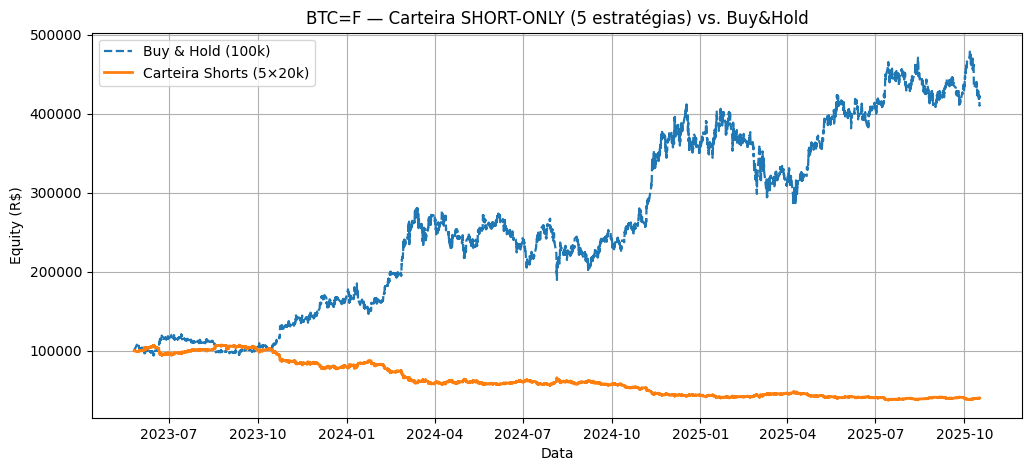


==== Estatísticas — BTC=F (SHORT-ONLY; 20,000 por estratégia) ====



,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
VWAP-Revert [SHORT],-38.20%,-0.93,-62.80%,-0.61,0.96,27.48%,705
Donchian24 [SHORT],-40.33%,-0.99,-71.07%,-0.57,0.96,72.29%,248
"EMAcross(20,50) [SHORT]",-44.84%,-1.18,-71.63%,-0.63,0.95,62.63%,296
RSI(14)Rev [SHORT],-47.97%,-1.37,-71.54%,-0.67,0.93,20.00%,109
"ATR-BO(14,0.75) [SHORT]",-50.37%,-1.43,-70.52%,-0.71,0.93,59.84%,1416


[OK] Export: /content/output/BTCF_shortonly_stats.csv
[OK] Export: /content/output/BTCF_shortonly_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


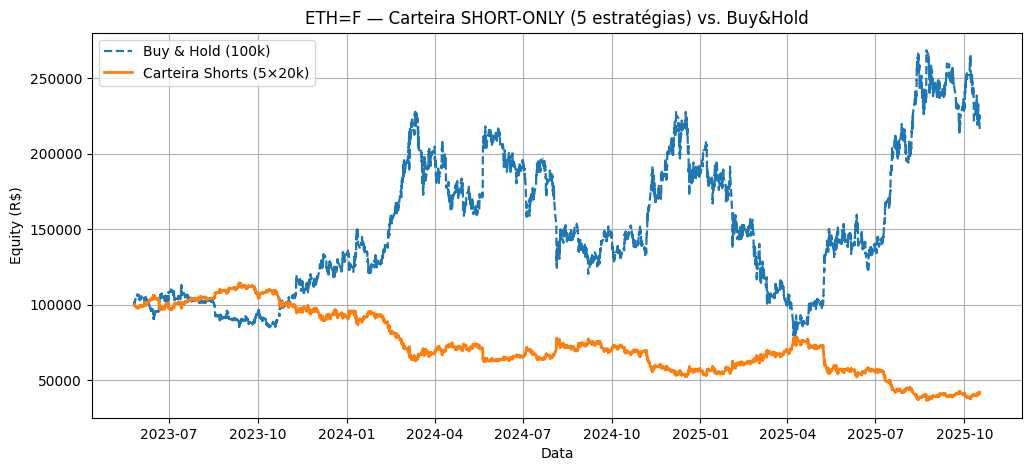


==== Estatísticas — ETH=F (SHORT-ONLY; 20,000 por estratégia) ====



,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
VWAP-Revert [SHORT],-30.12%,-0.35,-64.18%,-0.47,0.98,30.53%,713
Donchian24 [SHORT],-39.04%,-0.61,-68.21%,-0.57,0.97,76.63%,260
"EMAcross(20,50) [SHORT]",-44.45%,-0.78,-71.62%,-0.62,0.96,64.95%,290
RSI(14)Rev [SHORT],-46.20%,-0.81,-73.03%,-0.63,0.96,21.31%,121
"ATR-BO(14,0.75) [SHORT]",-53.53%,-1.13,-76.97%,-0.70,0.95,61.26%,1411


[OK] Export: /content/output/ETHF_shortonly_stats.csv
[OK] Export: /content/output/ETHF_shortonly_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


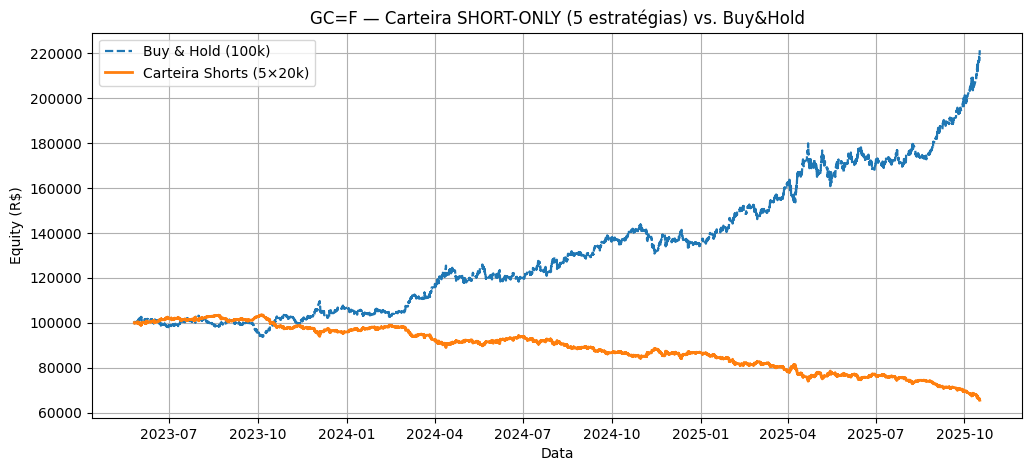


==== Estatísticas — GC=F (SHORT-ONLY; 20,000 por estratégia) ====



,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
RSI(14)Rev [SHORT],-13.90%,-1.20,-25.28%,-0.55,0.94,20.56%,106
VWAP-Revert [SHORT],-15.38%,-1.16,-24.22%,-0.63,0.95,26.96%,700
"ATR-BO(14,0.75) [SHORT]",-27.31%,-2.25,-44.39%,-0.62,0.90,60.14%,1173
Donchian24 [SHORT],-28.02%,-2.15,-43.89%,-0.64,0.91,69.52%,209
"EMAcross(20,50) [SHORT]",-33.80%,-2.82,-50.93%,-0.66,0.89,62.30%,251


[OK] Export: /content/output/GCF_shortonly_stats.csv
[OK] Export: /content/output/GCF_shortonly_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


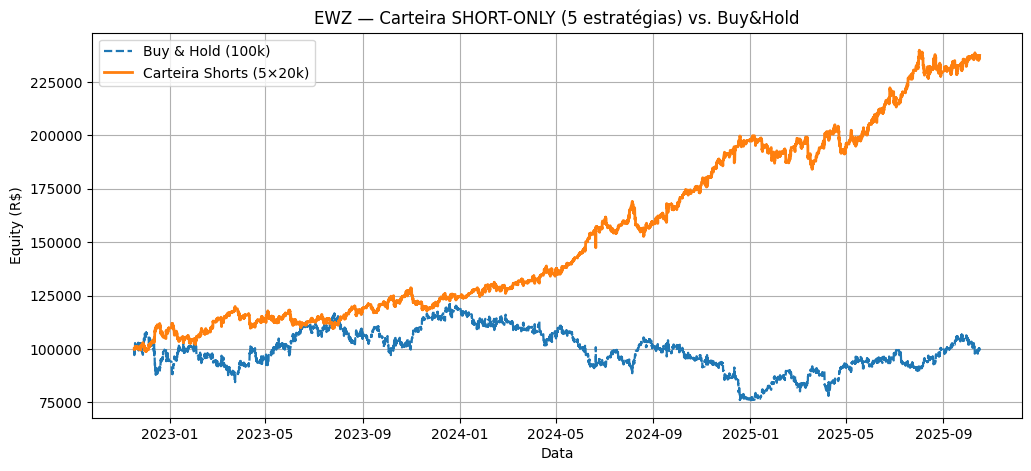


==== Estatísticas — EWZ (SHORT-ONLY; 20,000 por estratégia) ====



,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
"ATR-BO(14,0.75) [SHORT]",361.77%,4.58,-10.25%,35.30,1.25,58.80%,1482
Donchian24 [SHORT],79.05%,1.97,-14.49%,5.46,1.10,80.18%,226
"EMAcross(20,50) [SHORT]",36.54%,1.10,-25.48%,1.43,1.05,74.58%,239
RSI(14)Rev [SHORT],-14.85%,-0.30,-33.05%,-0.45,0.99,25.00%,75
VWAP-Revert [SHORT],-71.47%,-3.61,-80.86%,-0.88,0.84,25.15%,667


[OK] Export: /content/output/EWZ_shortonly_stats.csv
[OK] Export: /content/output/EWZ_shortonly_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


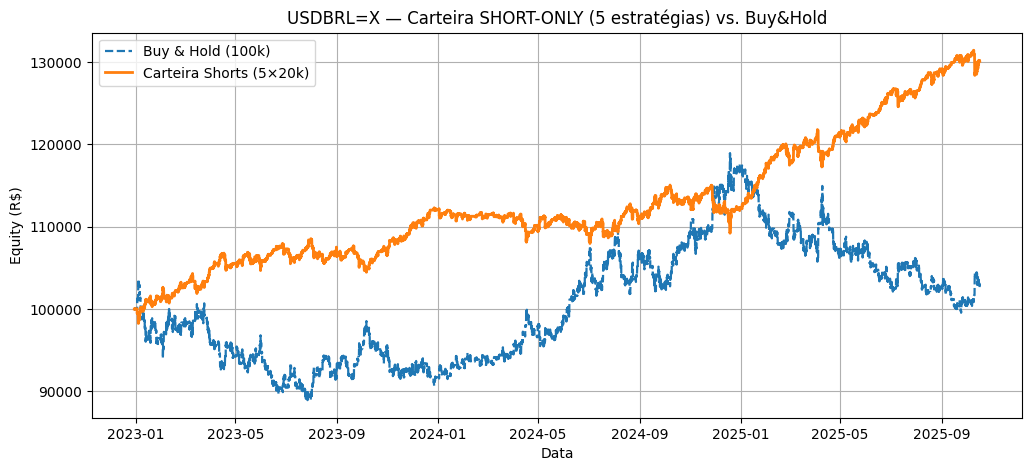


==== Estatísticas — USDBRL=X (SHORT-ONLY; 20,000 por estratégia) ====



,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
"ATR-BO(14,0.75) [SHORT]",100.67%,4.93,-5.93%,16.96,1.28,57.96%,1895
Donchian24 [SHORT],3.85%,0.33,-13.97%,0.28,1.02,74.89%,222
"EMAcross(20,50) [SHORT]",3.36%,0.30,-16.13%,0.21,1.02,63.79%,242
VWAP-Revert [SHORT],0.00%,nan,0.00%,nan,nan,nan%,0
RSI(14)Rev [SHORT],-16.35%,-1.32,-25.90%,-0.63,0.94,17.95%,116


[OK] Export: /content/output/USDBRLX_shortonly_stats.csv
[OK] Export: /content/output/USDBRLX_shortonly_curves.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


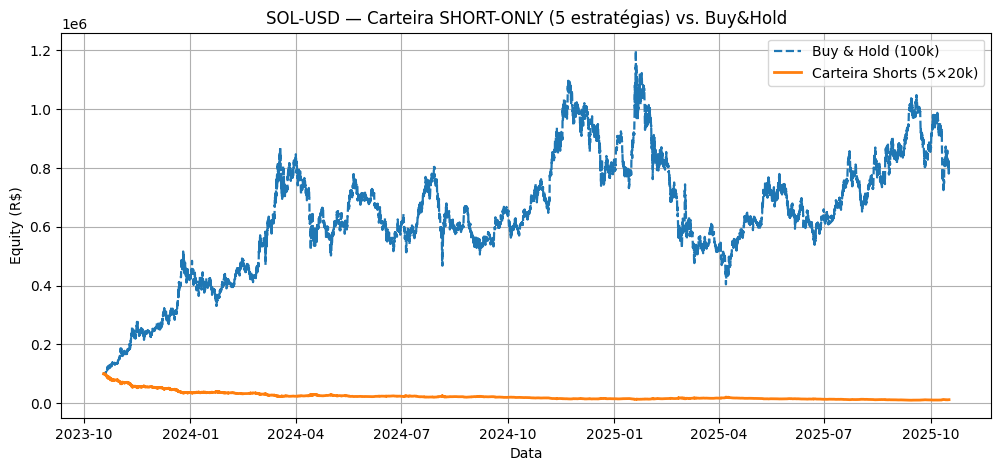


==== Estatísticas — SOL-USD (SHORT-ONLY; 20,000 por estratégia) ====



,CAGR,Sharpe,MaxDD,MAR,ProfitFactor,WinRate,Trades
Strategy,,,,,,,
RSI(14)Rev [SHORT],-54.22%,-0.92,-84.12%,-0.64,0.96,21.09%,127
VWAP-Revert [SHORT],-54.41%,-0.88,-83.84%,-0.65,0.96,28.45%,941
"ATR-BO(14,0.75) [SHORT]",-70.37%,-1.45,-92.13%,-0.76,0.94,59.92%,2559
Donchian24 [SHORT],-76.77%,-1.81,-94.97%,-0.81,0.92,74.23%,356
"EMAcross(20,50) [SHORT]",-78.37%,-1.92,-95.67%,-0.82,0.92,63.52%,306


[OK] Export: /content/output/SOL-USD_shortonly_stats.csv
[OK] Export: /content/output/SOL-USD_shortonly_curves.csv


In [ ]:
# =========================================================
# CÉLULA — 5 estratégias “invertidas” (SHORT-ONLY) vs. Buy&Hold
#           • Converte cada estratégia para operar somente vendidos
#           • Carteira por ATIVO: 100k divididos igualmente entre as 5 (short-only)
#           • Gráfico: Buy&Hold (100k) vs. Carteira Shorts (5×20k)
#           • Tabela de métricas por estratégia (short-only)
# =========================================================
# Pré: assets, STRATS, signal_to_equity, perf_stats, returns_from_close,
#      equity_buyhold, INIT_PER_ASSET, COST_BP, PPY já definidos.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

OUT_DIR = "/content/output"
os.makedirs(OUT_DIR, exist_ok=True)

def to_short_only(sig: pd.Series) -> pd.Series:
    """
    Converte um sinal {-1,0,1} em short-only:
      - sinais de COMPRA (+1) viram VENDA (−1)
      - sinais de VENDA (−1) virariam compra (+1), mas como é short-only, zeramos esses (+1 → 0)
      - neutro permanece 0
    Resultado: {-1, 0}, apenas posições vendidas ou flat.
    """
    inv = -sig  # inverte
    inv = inv.clip(upper=0)  # remove qualquer long (+)
    inv = inv.fillna(0)
    return inv

short_stats = {}

for tk, df in assets.items():
    close = df["Close"].copy()
    ret   = returns_from_close(df)
    bh    = equity_buyhold(close, INIT_PER_ASSET)

    per_strat_cap = INIT_PER_ASSET / len(STRATS)
    eq_components = []
    rows = []

    for name, fn in STRATS.items():
        base_sig = fn(df)                 # sinal original {-1,0,1}
        sig_short = to_short_only(base_sig)  # apenas vendidos {-1,0}
        res = signal_to_equity(close, ret, sig_short, per_strat_cap, cost_bp=COST_BP)
        eq_components.append(res["equity"])
        st = perf_stats(res["equity"], res["strat_ret"], res["sig"], periods_per_year=PPY)
        st["Strategy"] = f"{name} [SHORT]"
        rows.append(st)

    short_port = pd.concat(eq_components, axis=1).sum(axis=1)

    # --------- Gráfico ---------
    plt.figure()
    plt.plot(bh.index, bh.values, label="Buy & Hold (100k)", linestyle="--", linewidth=1.6)
    plt.plot(short_port.index, short_port.values, label="Carteira Shorts (5×20k)", linewidth=2.0)
    plt.title(f"{tk} — Carteira SHORT-ONLY (5 estratégias) vs. Buy&Hold")
    plt.xlabel("Data"); plt.ylabel("Equity (R$)")
    plt.legend()
    plt.show()

    # --------- Estatísticas ---------
    stats_df = pd.DataFrame(rows).set_index("Strategy").sort_values("CAGR", ascending=False)
    short_stats[tk] = stats_df
    print(f"\n==== Estatísticas — {tk} (SHORT-ONLY; {per_strat_cap:,.0f} por estratégia) ====\n")
    display(stats_df.style.format({
        "CAGR": "{:.2%}", "Sharpe": "{:.2f}", "MaxDD": "{:.2%}", "MAR": "{:.2f}",
        "ProfitFactor": "{:.2f}", "WinRate": "{:.2%}", "Trades": "{:.0f}"
    }))

    # --------- Export ---------
    base = tk.replace('=','').replace('^','_').replace('/','_')
    # a) estatísticas por estratégia (short-only)
    stats_path = os.path.join(OUT_DIR, f"{base}_shortonly_stats.csv")
    stats_df.to_csv(stats_path)
    # b) curvas BH e carteira short-only
    curves_df = pd.concat({"BuyHold": bh, "ShortOnly_Portfolio": short_port}, axis=1)
    curves_path = os.path.join(OUT_DIR, f"{base}_shortonly_curves.csv")
    curves_df.to_csv(curves_path)
    print("[OK] Export:", stats_path)
    print("[OK] Export:", curves_path)


In [ ]:
# =========================================================
# CÉLULA — Tabelas de MÉDIA e MEDIANA por ESTRATÉGIA (2 semanas)
# Para CADA ATIVO:
#   • Calcula retornos horários de 5 estratégias [LONG] + 5 [SHORT]
#   • Agrega para janelas de 2 semanas (2W-FRI) com retorno composto
#   • Tabela FINAL por ativo: linhas = estratégias (10), colunas = Mean_2W, Median_2W, Windows
#   • Exporta CSV por ativo e um CSV consolidado com todos os ativos
# =========================================================
# Pré: assets, STRATS, COST_BP já definidos nas células anteriores.

import os
import numpy as np
import pandas as pd

OUT_DIR = "/content/output"
os.makedirs(OUT_DIR, exist_ok=True)

def to_short_only(sig: pd.Series) -> pd.Series:
    """Inverte e remove componente long → {-1, 0} (short-only)."""
    inv = -sig
    return inv.clip(upper=0).fillna(0)

def compound(r: pd.Series) -> float:
    """Retorno composto no período: (1+r).prod()-1."""
    if r is None or len(r) == 0:
        return np.nan
    return float((1.0 + r).prod() - 1.0)

def hourly_strat_ret(df: pd.DataFrame, sig: pd.Series, cost_bp: float = 0.0) -> pd.Series:
    """Retorno horário da estratégia a partir de Close e sinal (-1/0/1)."""
    close = df["Close"]
    ret = close.pct_change().fillna(0.0)
    sig = sig.reindex(ret.index).fillna(0)
    turns = sig.diff().abs().fillna(0)
    cost = (cost_bp / 10000.0) * turns   # custo ida+volta (bps) quando muda posição
    strat_ret = sig.shift(1).fillna(0) * ret - cost
    strat_ret.name = "strat_ret"
    return strat_ret

tables_by_asset = {}
consolidated_rows = []

for tk, df in assets.items():
    # 1) Retornos horários para todas as 10 estratégias (5 long + 5 short)
    ret_cols = {}
    for name, fn in STRATS.items():
        sig_long = fn(df)
        r_long = hourly_strat_ret(df, sig_long, cost_bp=COST_BP)
        ret_cols[f"{name} [LONG]"] = r_long

        sig_short = to_short_only(sig_long)
        r_short = hourly_strat_ret(df, sig_short, cost_bp=COST_BP)
        ret_cols[f"{name} [SHORT]"] = r_short

    ret_hourly = pd.DataFrame(ret_cols).dropna(how="all")
    if ret_hourly.empty:
        print(f"[WARN] {tk}: sem retornos calculados — verifique dados.")
        continue

    # 2) Agrega para DIÁRIO (composto por dia) e depois 2 SEMANAS (2W-FRI)
    ret_daily = ret_hourly.groupby(ret_hourly.index.normalize()).apply(lambda x: (1.0 + x).prod() - 1.0)
    ret_2w = ret_daily.resample("2W-FRI").apply(compound)  # cada coluna = série 2W da estratégia

    # 3) Para cada estratégia, calcule média e mediana no TEMPO (todas as janelas 2W)
    mean_by_strat = ret_2w.mean(axis=0).rename("Mean_2W")
    median_by_strat = ret_2w.median(axis=0).rename("Median_2W")
    n_windows = ret_2w.count(axis=0).rename("Windows")

    table = pd.concat([mean_by_strat, median_by_strat, n_windows], axis=1).sort_index()
    tables_by_asset[tk] = table

    # Export por ativo
    base = tk.replace('=','').replace('^','_').replace('/','_')
    path = os.path.join(OUT_DIR, f"{base}_by_strategy_mean_median_2w.csv")
    table.to_csv(path)
    print("[OK] Export:", path)

    # para consolidado
    tmp = table.copy()
    tmp.insert(0, "Asset", tk)
    tmp.insert(1, "Strategy", tmp.index)
    consolidated_rows.append(tmp.reset_index(drop=True))

# 4) Mostrar as tabelas (formatação %)
for tk, tbl in tables_by_asset.items():
    print(f"\n==== {tk} — Média e Mediana por Estratégia (janelas 2W) ====")
    display(tbl.style.format({"Mean_2W": "{:.2%}", "Median_2W": "{:.2%}", "Windows": "{:.0f}"}))

# 5) Consolidado (todos os ativos)
if consolidated_rows:
    all_df = pd.concat(consolidated_rows, ignore_index=True)
    all_path = os.path.join(OUT_DIR, "ALL_assets_by_strategy_mean_median_2w.csv")
    all_df.to_csv(all_path, index=False)
    print("\n[OK] Export consolidado:", all_path)
else:
    print("\n[WARN] Nada para consolidar.")


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export: /content/output/BTCF_by_strategy_mean_median_2w.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export: /content/output/ETHF_by_strategy_mean_median_2w.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export: /content/output/GCF_by_strategy_mean_median_2w.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export: /content/output/EWZ_by_strategy_mean_median_2w.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export: /content/output/USDBRLX_by_strategy_mean_median_2w.csv


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


[OK] Export: /content/output/SOL-USD_by_strategy_mean_median_2w.csv

==== BTC=F — Média e Mediana por Estratégia (janelas 2W) ====


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",0.35%,-1.05%,64
"ATR-BO(14,0.75) [SHORT]",-1.53%,-1.26%,64
Donchian24 [LONG],-0.41%,-0.05%,64
Donchian24 [SHORT],-0.96%,-0.30%,64
"EMAcross(20,50) [LONG]",-0.05%,0.67%,64
"EMAcross(20,50) [SHORT]",-1.14%,-0.22%,64
RSI(14)Rev [LONG],0.27%,-0.92%,64
RSI(14)Rev [SHORT],-1.47%,-0.29%,64
VWAP-Revert [LONG],-0.82%,-0.84%,64
VWAP-Revert [SHORT],-1.05%,-1.15%,64



==== ETH=F — Média e Mediana por Estratégia (janelas 2W) ====


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",0.73%,0.29%,64
"ATR-BO(14,0.75) [SHORT]",-1.60%,-0.12%,64
Donchian24 [LONG],-0.31%,-2.30%,64
Donchian24 [SHORT],-0.74%,0.73%,64
"EMAcross(20,50) [LONG]",0.25%,-0.96%,64
"EMAcross(20,50) [SHORT]",-0.86%,0.70%,64
RSI(14)Rev [LONG],0.26%,-0.94%,64
RSI(14)Rev [SHORT],-1.37%,-0.49%,64
VWAP-Revert [LONG],-1.16%,-1.48%,64
VWAP-Revert [SHORT],-0.58%,-0.54%,64



==== GC=F — Média e Mediana por Estratégia (janelas 2W) ====


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",0.25%,0.65%,64
"ATR-BO(14,0.75) [SHORT]",-0.76%,-0.89%,64
Donchian24 [LONG],0.29%,-0.03%,64
Donchian24 [SHORT],-0.79%,-0.62%,64
"EMAcross(20,50) [LONG]",0.71%,0.93%,64
"EMAcross(20,50) [SHORT]",-0.99%,-1.06%,64
RSI(14)Rev [LONG],-0.58%,-0.73%,64
RSI(14)Rev [SHORT],-0.36%,-0.32%,64
VWAP-Revert [LONG],-0.51%,-0.38%,64
VWAP-Revert [SHORT],-0.40%,-0.45%,64



==== EWZ — Média e Mediana por Estratégia (janelas 2W) ====


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",-5.38%,-5.24%,77
"ATR-BO(14,0.75) [SHORT]",2.69%,2.07%,77
Donchian24 [LONG],-2.24%,-1.76%,77
Donchian24 [SHORT],1.05%,0.98%,77
"EMAcross(20,50) [LONG]",-1.46%,-1.60%,77
"EMAcross(20,50) [SHORT]",0.58%,1.12%,77
RSI(14)Rev [LONG],0.13%,-0.58%,77
RSI(14)Rev [SHORT],-0.21%,-0.11%,77
VWAP-Revert [LONG],3.84%,3.52%,77
VWAP-Revert [SHORT],-2.02%,-1.88%,77



==== USDBRL=X — Média e Mediana por Estratégia (janelas 2W) ====


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",-2.69%,-2.37%,74
"ATR-BO(14,0.75) [SHORT]",1.33%,1.10%,74
Donchian24 [LONG],-0.25%,-0.02%,74
Donchian24 [SHORT],0.08%,0.03%,74
"EMAcross(20,50) [LONG]",-0.26%,-0.17%,74
"EMAcross(20,50) [SHORT]",0.07%,0.25%,74
RSI(14)Rev [LONG],0.56%,0.72%,74
RSI(14)Rev [SHORT],-0.32%,-0.44%,74
VWAP-Revert [LONG],0.00%,0.00%,74
VWAP-Revert [SHORT],0.00%,0.00%,74



==== SOL-USD — Média e Mediana por Estratégia (janelas 2W) ====


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",1.07%,-0.82%,53
"ATR-BO(14,0.75) [SHORT]",-3.98%,-2.22%,53
Donchian24 [LONG],2.92%,3.37%,53
Donchian24 [SHORT],-4.60%,-3.70%,53
"EMAcross(20,50) [LONG]",3.33%,1.81%,53
"EMAcross(20,50) [SHORT]",-4.91%,-2.25%,53
RSI(14)Rev [LONG],-1.50%,-3.10%,53
RSI(14)Rev [SHORT],-2.48%,-2.68%,53
VWAP-Revert [LONG],-2.11%,-3.43%,53
VWAP-Revert [SHORT],-2.35%,-2.85%,53



[OK] Export consolidado: /content/output/ALL_assets_by_strategy_mean_median_2w.csv


In [ ]:
# =========================================================
# CÉLULA — Tabelas 2W (LONG+SHORT) e remoção do melhor LONG e melhor SHORT por ativo
# Saídas:
#  - tables_by_asset: tabela completa (10 estratégias) por ativo, com Mean_2W, Median_2W, Windows
#  - pruned_tables_by_asset: tabela sem o melhor [LONG] e o melhor [SHORT]
#  - CSVs exportados em /content/output
# Pré: assets, STRATS, COST_BP definidos nas células anteriores.
# =========================================================
import os
import numpy as np
import pandas as pd

OUT_DIR = "/content/output"
os.makedirs(OUT_DIR, exist_ok=True)

RANK_FIELD = "Mean_2W"   # mude para "Median_2W" se quiser ranquear pela mediana

def to_short_only(sig: pd.Series) -> pd.Series:
    inv = -sig
    return inv.clip(upper=0).fillna(0)

def compound(r: pd.Series) -> float:
    return float((1.0 + r).prod() - 1.0) if (r is not None and len(r) > 0) else np.nan

def hourly_strat_ret(df: pd.DataFrame, sig: pd.Series, cost_bp: float = 0.0) -> pd.Series:
    close = df["Close"]
    ret = close.pct_change().fillna(0.0)
    sig = sig.reindex(ret.index).fillna(0)
    turns = sig.diff().abs().fillna(0)
    cost = (cost_bp / 10000.0) * turns
    strat_ret = sig.shift(1).fillna(0) * ret - cost
    strat_ret.name = "strat_ret"
    return strat_ret

# ---------- (Re)constrói tables_by_asset se não existir ----------
need_build = "tables_by_asset" not in globals()
if need_build:
    tables_by_asset = {}

for tk, df in assets.items():
    if need_build:
        # 1) Retornos horários para 10 estratégias (5 LONG + 5 SHORT)
        ret_cols = {}
        for name, fn in STRATS.items():
            sig_long = fn(df)
            r_long = hourly_strat_ret(df, sig_long, cost_bp=COST_BP)
            ret_cols[f"{name} [LONG]"] = r_long

            sig_short = to_short_only(sig_long)
            r_short = hourly_strat_ret(df, sig_short, cost_bp=COST_BP)
            ret_cols[f"{name} [SHORT]"] = r_short

        ret_hourly = pd.DataFrame(ret_cols).dropna(how="all")
        if ret_hourly.empty:
            print(f"[WARN] {tk}: sem retornos; pulando.")
            continue

        # 2) Diário composto, depois janelas 2W-FRI
        ret_daily = ret_hourly.groupby(ret_hourly.index.normalize()).apply(lambda x: (1.0 + x).prod() - 1.0)
        ret_2w = ret_daily.resample("2W-FRI").apply(compound)

        # 3) mean/median por estratégia ao longo de TODAS as janelas 2W
        mean_by_strat = ret_2w.mean(axis=0).rename("Mean_2W")
        median_by_strat = ret_2w.median(axis=0).rename("Median_2W")
        n_windows = ret_2w.count(axis=0).rename("Windows")

        table = pd.concat([mean_by_strat, median_by_strat, n_windows], axis=1).sort_index()
        tables_by_asset[tk] = table

# ---------- Remoção do melhor LONG e melhor SHORT ----------
pruned_tables_by_asset = {}
removed_by_asset = {}

for tk, table in tables_by_asset.items():
    longs  = table.loc[[i for i in table.index if i.endswith("[LONG]")]]
    shorts = table.loc[[i for i in table.index if i.endswith("[SHORT]")]]

    best_long  = longs[RANK_FIELD].idxmax()  if len(longs)  else None
    best_short = shorts[RANK_FIELD].idxmax() if len(shorts) else None

    removed = [x for x in [best_long, best_short] if x is not None]
    removed_by_asset[tk] = removed

    pruned = table.drop(index=removed, errors="ignore")
    pruned_tables_by_asset[tk] = pruned

    # Exporta as tabelas completa e podada
    base = tk.replace('=','').replace('^','_').replace('/','_')
    table.to_csv(os.path.join(OUT_DIR, f"{base}_by_strategy_mean_median_2w.csv"))
    pruned.to_csv(os.path.join(OUT_DIR, f"{base}_by_strategy_mean_median_2w_PRUNED.csv"))

    print(f"{tk}: removidos → {', '.join(removed) if removed else 'nenhum'}")
    display(pruned.style.format({"Mean_2W": "{:.2%}", "Median_2W": "{:.2%}", "Windows": "{:.0f}"}))

print("\nArquivos exportados em:", OUT_DIR)


BTC=F: removidos → ATR-BO(14,0.75) [LONG], Donchian24 [SHORT]


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [SHORT]",-1.53%,-1.26%,64
Donchian24 [LONG],-0.41%,-0.05%,64
"EMAcross(20,50) [LONG]",-0.05%,0.67%,64
"EMAcross(20,50) [SHORT]",-1.14%,-0.22%,64
RSI(14)Rev [LONG],0.27%,-0.92%,64
RSI(14)Rev [SHORT],-1.47%,-0.29%,64
VWAP-Revert [LONG],-0.82%,-0.84%,64
VWAP-Revert [SHORT],-1.05%,-1.15%,64


ETH=F: removidos → ATR-BO(14,0.75) [LONG], VWAP-Revert [SHORT]


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [SHORT]",-1.60%,-0.12%,64
Donchian24 [LONG],-0.31%,-2.30%,64
Donchian24 [SHORT],-0.74%,0.73%,64
"EMAcross(20,50) [LONG]",0.25%,-0.96%,64
"EMAcross(20,50) [SHORT]",-0.86%,0.70%,64
RSI(14)Rev [LONG],0.26%,-0.94%,64
RSI(14)Rev [SHORT],-1.37%,-0.49%,64
VWAP-Revert [LONG],-1.16%,-1.48%,64


GC=F: removidos → EMAcross(20,50) [LONG], RSI(14)Rev [SHORT]


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",0.25%,0.65%,64
"ATR-BO(14,0.75) [SHORT]",-0.76%,-0.89%,64
Donchian24 [LONG],0.29%,-0.03%,64
Donchian24 [SHORT],-0.79%,-0.62%,64
"EMAcross(20,50) [SHORT]",-0.99%,-1.06%,64
RSI(14)Rev [LONG],-0.58%,-0.73%,64
VWAP-Revert [LONG],-0.51%,-0.38%,64
VWAP-Revert [SHORT],-0.40%,-0.45%,64


EWZ: removidos → VWAP-Revert [LONG], ATR-BO(14,0.75) [SHORT]


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",-5.38%,-5.24%,77
Donchian24 [LONG],-2.24%,-1.76%,77
Donchian24 [SHORT],1.05%,0.98%,77
"EMAcross(20,50) [LONG]",-1.46%,-1.60%,77
"EMAcross(20,50) [SHORT]",0.58%,1.12%,77
RSI(14)Rev [LONG],0.13%,-0.58%,77
RSI(14)Rev [SHORT],-0.21%,-0.11%,77
VWAP-Revert [SHORT],-2.02%,-1.88%,77


USDBRL=X: removidos → RSI(14)Rev [LONG], ATR-BO(14,0.75) [SHORT]


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",-2.69%,-2.37%,74
Donchian24 [LONG],-0.25%,-0.02%,74
Donchian24 [SHORT],0.08%,0.03%,74
"EMAcross(20,50) [LONG]",-0.26%,-0.17%,74
"EMAcross(20,50) [SHORT]",0.07%,0.25%,74
RSI(14)Rev [SHORT],-0.32%,-0.44%,74
VWAP-Revert [LONG],0.00%,0.00%,74
VWAP-Revert [SHORT],0.00%,0.00%,74


SOL-USD: removidos → EMAcross(20,50) [LONG], VWAP-Revert [SHORT]


,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",1.07%,-0.82%,53
"ATR-BO(14,0.75) [SHORT]",-3.98%,-2.22%,53
Donchian24 [LONG],2.92%,3.37%,53
Donchian24 [SHORT],-4.60%,-3.70%,53
"EMAcross(20,50) [SHORT]",-4.91%,-2.25%,53
RSI(14)Rev [LONG],-1.50%,-3.10%,53
RSI(14)Rev [SHORT],-2.48%,-2.68%,53
VWAP-Revert [LONG],-2.11%,-3.43%,53



Arquivos exportados em: /content/output


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


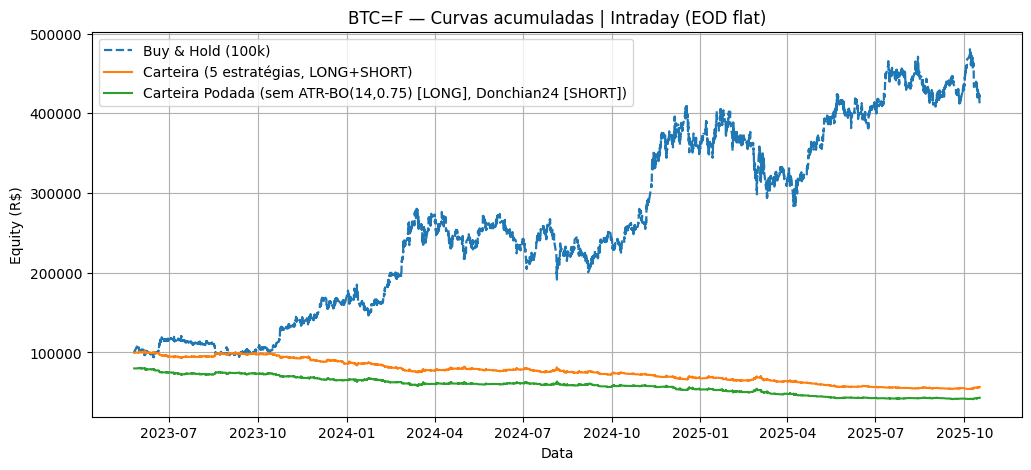

,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [SHORT]",-1.53%,-1.26%,64
Donchian24 [LONG],-0.41%,-0.05%,64
"EMAcross(20,50) [LONG]",-0.05%,0.67%,64
"EMAcross(20,50) [SHORT]",-1.14%,-0.22%,64
RSI(14)Rev [LONG],0.27%,-0.92%,64
RSI(14)Rev [SHORT],-1.47%,-0.29%,64
VWAP-Revert [LONG],-0.82%,-0.84%,64
VWAP-Revert [SHORT],-1.05%,-1.15%,64


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


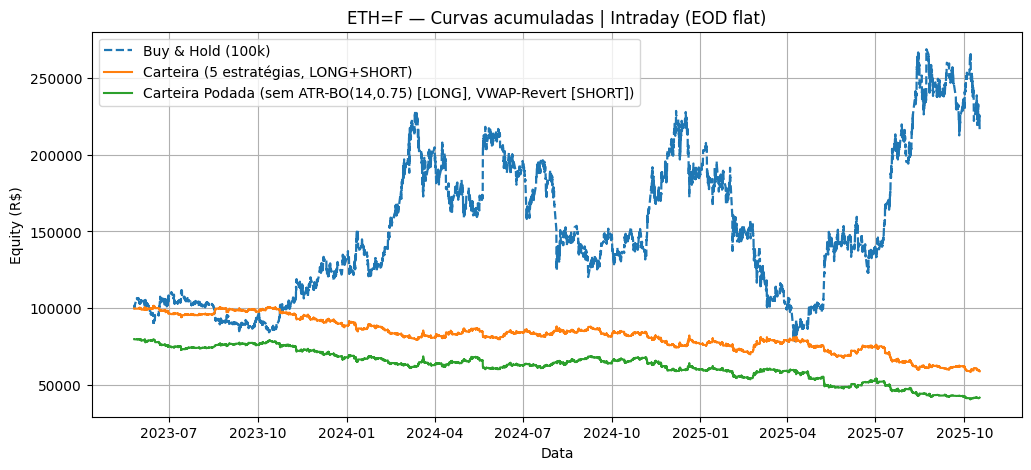

,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [SHORT]",-1.60%,-0.12%,64
Donchian24 [LONG],-0.31%,-2.30%,64
Donchian24 [SHORT],-0.74%,0.73%,64
"EMAcross(20,50) [LONG]",0.25%,-0.96%,64
"EMAcross(20,50) [SHORT]",-0.86%,0.70%,64
RSI(14)Rev [LONG],0.26%,-0.94%,64
RSI(14)Rev [SHORT],-1.37%,-0.49%,64
VWAP-Revert [LONG],-1.16%,-1.48%,64


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


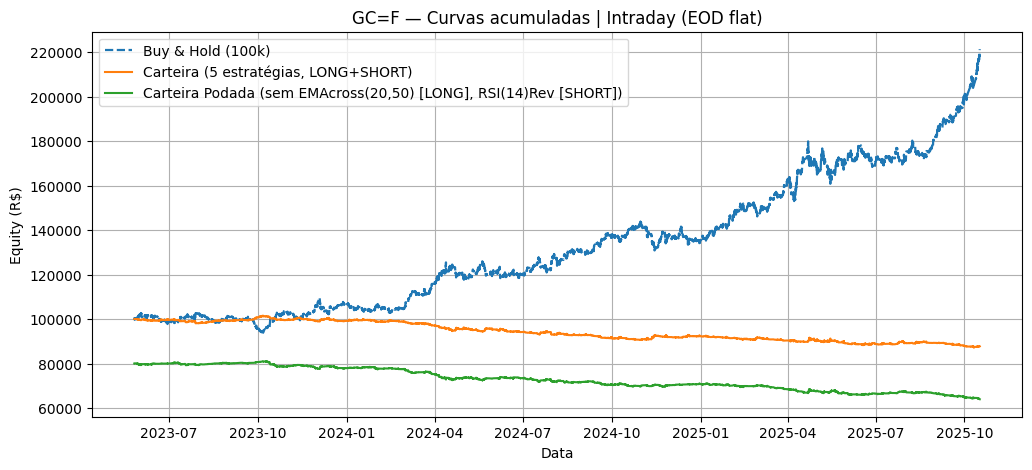

,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",0.25%,0.65%,64
"ATR-BO(14,0.75) [SHORT]",-0.76%,-0.89%,64
Donchian24 [LONG],0.29%,-0.03%,64
Donchian24 [SHORT],-0.79%,-0.62%,64
"EMAcross(20,50) [SHORT]",-0.99%,-1.06%,64
RSI(14)Rev [LONG],-0.58%,-0.73%,64
VWAP-Revert [LONG],-0.51%,-0.38%,64
VWAP-Revert [SHORT],-0.40%,-0.45%,64


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


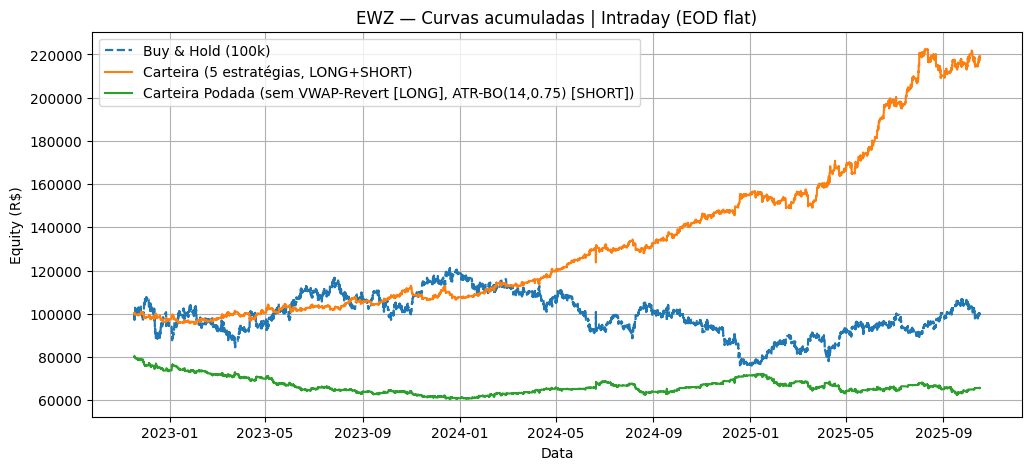

,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",-5.38%,-5.24%,77
Donchian24 [LONG],-2.24%,-1.76%,77
Donchian24 [SHORT],1.05%,0.98%,77
"EMAcross(20,50) [LONG]",-1.46%,-1.60%,77
"EMAcross(20,50) [SHORT]",0.58%,1.12%,77
RSI(14)Rev [LONG],0.13%,-0.58%,77
RSI(14)Rev [SHORT],-0.21%,-0.11%,77
VWAP-Revert [SHORT],-2.02%,-1.88%,77


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


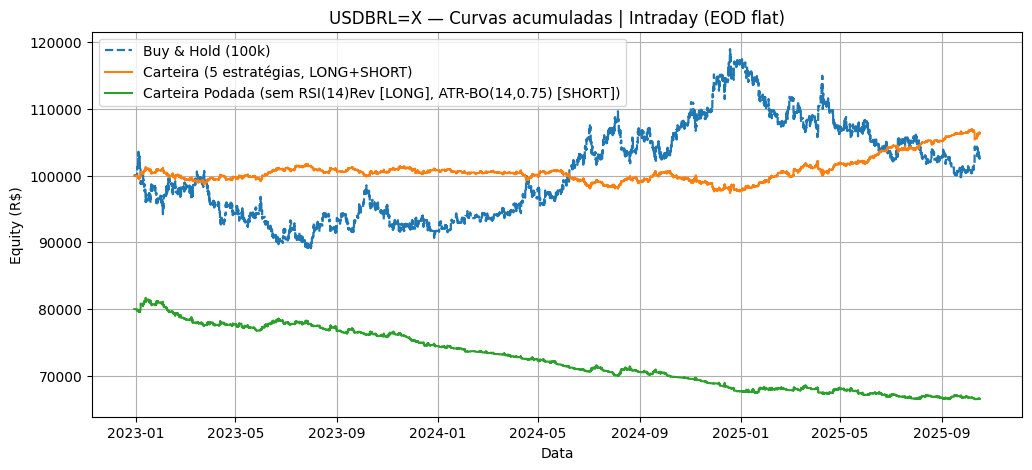

,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",-2.69%,-2.37%,74
Donchian24 [LONG],-0.25%,-0.02%,74
Donchian24 [SHORT],0.08%,0.03%,74
"EMAcross(20,50) [LONG]",-0.26%,-0.17%,74
"EMAcross(20,50) [SHORT]",0.07%,0.25%,74
RSI(14)Rev [SHORT],-0.32%,-0.44%,74
VWAP-Revert [LONG],0.00%,0.00%,74
VWAP-Revert [SHORT],0.00%,0.00%,74


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")


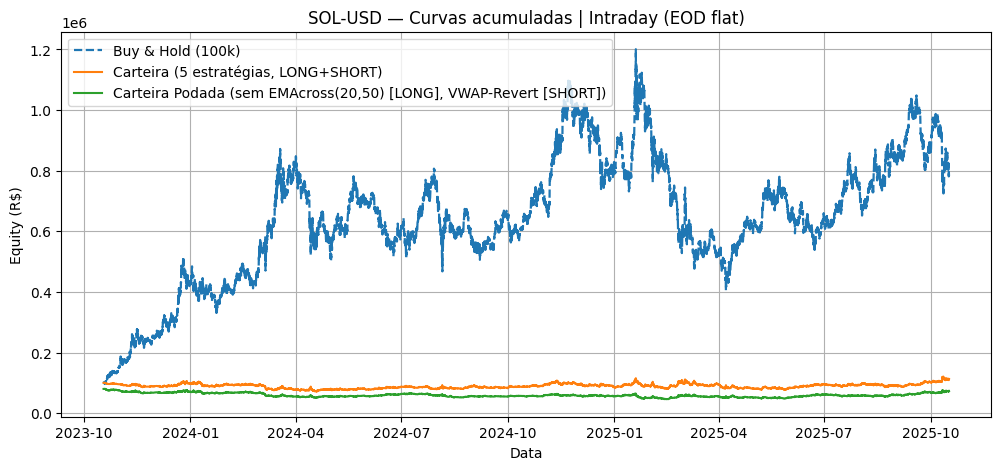

,Mean_2W,Median_2W,Windows
"ATR-BO(14,0.75) [LONG]",1.07%,-0.82%,53
"ATR-BO(14,0.75) [SHORT]",-3.98%,-2.22%,53
Donchian24 [LONG],2.92%,3.37%,53
Donchian24 [SHORT],-4.60%,-3.70%,53
"EMAcross(20,50) [SHORT]",-4.91%,-2.25%,53
RSI(14)Rev [LONG],-1.50%,-3.10%,53
RSI(14)Rev [SHORT],-2.48%,-2.68%,53
VWAP-Revert [LONG],-2.11%,-3.43%,53



Arquivos exportados em: /content/output

Obs.: Para intraday (fechar tudo no dia), deixe EOD_FLAT=True. Para permitir overnight, use False.


In [ ]:
# =========================================================
# CÉLULA — Tabelas 2W + remoção do melhor LONG/SHORT
#           + GRÁFICOS acumulados (BH vs 5 Strats vs Podada)
#           + Opção de intraday (EOD_FLAT)
# Pré: assets, STRATS, COST_BP, equity_buyhold já definidos.
# =========================================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "/content/output"
os.makedirs(OUT_DIR, exist_ok=True)

# ====== CONFIG ======
RANK_FIELD = "Mean_2W"  # ou "Median_2W"
INIT_PER_ASSET = 100_000.0
COST_BP = globals().get("COST_BP", 0.0)  # usa o que você já definiu antes
EOD_FLAT = True  # <<< coloque True para intraday (fecha posição no fim do dia); False para permitir overnight
PPY = 24*365     # anualização para 1h (seu ambiente anterior usa isso)

# ====== Helpers ======
def to_short_only(sig: pd.Series) -> pd.Series:
    inv = -sig
    return inv.clip(upper=0).fillna(0)

def apply_eod_flat(sig: pd.Series) -> pd.Series:
    """Zera a posição no último candle de cada dia (intraday-only)."""
    if sig.empty:
        return sig
    s = sig.copy().astype(float)
    # encontra o último timestamp de cada dia
    last_per_day = s.groupby(s.index.normalize()).tail(1).index
    # zera posição nesses últimos candles -> a posição do próximo dia (sig.shift(1)) será 0
    s.loc[last_per_day] = 0.0
    return s

def hourly_strat_ret(df: pd.DataFrame, sig: pd.Series, cost_bp: float = 0.0) -> pd.Series:
    close = df["Close"]
    ret = close.pct_change().fillna(0.0)
    sig = sig.reindex(ret.index).fillna(0.0)
    turns = sig.diff().abs().fillna(0.0)
    cost = (cost_bp / 10000.0) * turns
    strat_ret = sig.shift(1).fillna(0.0) * ret - cost
    strat_ret.name = "strat_ret"
    return strat_ret

def compound_period(r: pd.Series) -> float:
    return float((1.0 + r).prod() - 1.0) if (r is not None and len(r) > 0) else np.nan

def build_equity_from_signal(df: pd.DataFrame, sig: pd.Series, capital: float, cost_bp: float) -> pd.Series:
    r = hourly_strat_ret(df, sig, cost_bp=cost_bp)
    eq = (1.0 + r).cumprod() * capital
    eq.name = "equity"
    return eq

# ====== (Re)constrói tabelas 2W se necessário ======
need_build = "tables_by_asset" not in globals()
if need_build:
    tables_by_asset = {}

for tk, df in assets.items():
    if need_build:
        # construímos retornos horários LONG/SHORT para as 5 estratégias
        ret_cols = {}
        for name, fn in STRATS.items():
            sig_long = fn(df)
            if EOD_FLAT:
                sig_long = apply_eod_flat(sig_long)
            r_long = hourly_strat_ret(df, sig_long, cost_bp=COST_BP)
            ret_cols[f"{name} [LONG]"] = r_long

            sig_short = to_short_only(sig_long)  # importante: aplique short sobre o sig já “flattened”, se EOD_FLAT
            if EOD_FLAT:
                sig_short = apply_eod_flat(sig_short)
            r_short = hourly_strat_ret(df, sig_short, cost_bp=COST_BP)
            ret_cols[f"{name} [SHORT]"] = r_short

        ret_hourly = pd.DataFrame(ret_cols).dropna(how="all")
        if ret_hourly.empty:
            print(f"[WARN] {tk}: sem retornos; pulando tabelas.")
            continue

        # diário composto e 2W-FRI
        ret_daily = ret_hourly.groupby(ret_hourly.index.normalize()).apply(lambda x: (1.0 + x).prod() - 1.0)
        ret_2w = ret_daily.resample("2W-FRI").apply(compound_period)

        # mean/median por estratégia ao longo de TODAS as janelas 2W
        mean_by_strat = ret_2w.mean(axis=0).rename("Mean_2W")
        median_by_strat = ret_2w.median(axis=0).rename("Median_2W")
        n_windows = ret_2w.count(axis=0).rename("Windows")
        table = pd.concat([mean_by_strat, median_by_strat, n_windows], axis=1).sort_index()
        tables_by_asset[tk] = table

# ====== Remoção do melhor LONG e melhor SHORT; curvas acumuladas ======
pruned_tables_by_asset = {}
removed_by_asset = {}

for tk, table in tables_by_asset.items():
    df = assets[tk]
    close = df["Close"]
    bh = (1.0 + close.pct_change().fillna(0.0)).cumprod() * INIT_PER_ASSET

    # identifica melhor long/short
    longs  = table.loc[[i for i in table.index if i.endswith("[LONG]")]]
    shorts = table.loc[[i for i in table.index if i.endswith("[SHORT]")]]

    best_long  = longs[RANK_FIELD].idxmax()  if len(longs)  else None
    best_short = shorts[RANK_FIELD].idxmax() if len(shorts) else None
    removed = [x for x in [best_long, best_short] if x is not None]
    removed_by_asset[tk] = removed

    # lista de todas as 10 estratégias
    all_names = table.index.tolist()
    # nomes "puros" das 5 estratégias para gerar sinal de novo
    base_names = list(STRATS.keys())

    # ===== Carteira 5 estratégias (todas) =====
    cap_each = INIT_PER_ASSET / len(base_names)
    eq_all = []
    for base in base_names:
        # LONG
        sig = STRATS[base](df)
        if EOD_FLAT:
            sig = apply_eod_flat(sig)
        eq = build_equity_from_signal(df, sig, cap_each/2, cost_bp=COST_BP)  # metade do capital para long
        # SHORT
        sig_s = to_short_only(sig)
        if EOD_FLAT:
            sig_s = apply_eod_flat(sig_s)
        eq_s = build_equity_from_signal(df, sig_s, cap_each/2, cost_bp=COST_BP)  # metade p/ short
        eq_all.append(eq.add(eq_s, fill_value=0.0))
    port_all = pd.concat(eq_all, axis=1).sum(axis=1)
    port_all.name = "Portfolio_All5"

    # ===== Carteira "podada" (remove melhor [LONG] e melhor [SHORT]) =====
    # mapeia removidos para seus "bases"
    removed_bases = set()
    for r in removed:
        for base in base_names:
            if r.startswith(base):
                removed_bases.add((base, "[LONG]" if "[LONG]" in r else "[SHORT]"))
                break

    eq_pruned = []
    for base in base_names:
        # LONG (só se não removido)
        if (base, "[LONG]") not in removed_bases:
            sigL = STRATS[base](df)
            if EOD_FLAT:
                sigL = apply_eod_flat(sigL)
            # capital re-dividido pelas “pernas” remanescentes
            eqL = build_equity_from_signal(df, sigL, INIT_PER_ASSET/ (2*len(base_names)), cost_bp=COST_BP)
        else:
            eqL = None
        # SHORT (só se não removido)
        if (base, "[SHORT]") not in removed_bases:
            # short é o inverso; derive a partir do sinal long já flatten se quiser consistência
            sig_base = STRATS[base](df)
            if EOD_FLAT:
                sig_base = apply_eod_flat(sig_base)
            sigS = to_short_only(sig_base)
            if EOD_FLAT:
                sigS = apply_eod_flat(sigS)
            eqS = build_equity_from_signal(df, sigS, INIT_PER_ASSET/ (2*len(base_names)), cost_bp=COST_BP)
        else:
            eqS = None

        pair = []
        if eqL is not None: pair.append(eqL)
        if eqS is not None: pair.append(eqS)
        if pair:
            eq_pruned.append(pd.concat(pair, axis=1).sum(axis=1))
    if eq_pruned:
        port_pruned = pd.concat(eq_pruned, axis=1).sum(axis=1)
    else:
        port_pruned = port_all.copy()  # fallback

    port_pruned.name = "Portfolio_Pruned"

    # ====== GRÁFICO ======
    plt.figure()
    plt.plot(bh.index, bh.values, label="Buy & Hold (100k)", linestyle="--", linewidth=1.6)
    plt.plot(port_all.index, port_all.values, label="Carteira (5 estratégias, LONG+SHORT)")
    plt.plot(port_pruned.index, port_pruned.values, label=f"Carteira Podada (sem {', '.join(removed)})")
    ttl = f"{tk} — Curvas acumuladas | {'Intraday (EOD flat)' if EOD_FLAT else 'Overnight permitido'}"
    plt.title(ttl)
    plt.xlabel("Data"); plt.ylabel("Equity (R$)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # ====== Exporta curvas ======
    base = tk.replace('=','').replace('^','_').replace('/','_')
    curves_df = pd.concat({"BuyHold": bh, "All5": port_all, "Pruned": port_pruned}, axis=1)
    curves_df.to_csv(os.path.join(OUT_DIR, f"{base}_curves_all_vs_pruned_{'EOD' if EOD_FLAT else 'OVN'}.csv"))

    # ====== Tabela PRUNED para conferência ======
    longs  = table.loc[[i for i in table.index if i.endswith("[LONG]")]]
    shorts = table.loc[[i for i in table.index if i.endswith("[SHORT]")]]
    best_long  = longs[RANK_FIELD].idxmax()  if len(longs)  else None
    best_short = shorts[RANK_FIELD].idxmax() if len(shorts) else None
    removed_by_asset[tk] = [x for x in [best_long, best_short] if x is not None]

    pruned = table.drop(index=removed_by_asset[tk], errors="ignore")
    display(pruned.style.format({"Mean_2W": "{:.2%}", "Median_2W": "{:.2%}", "Windows": "{:.0f}"}))

print("\nArquivos exportados em:", OUT_DIR)
print("\nObs.: Para intraday (fechar tudo no dia), deixe EOD_FLAT=True. Para permitir overnight, use False.")


In [ ]:
# =========================================================
# CÉLULA — Lista de trades (completa) por ativo e por estratégia (LONG e SHORT)
# Saídas:
#   • CSV por ativo: /content/output/<ASSET>_trades.csv
#   • CSV consolidado: /content/output/ALL_trades.csv
# Pré: assets, STRATS, COST_BP, EOD_FLAT, apply_eod_flat() e to_short_only() definidos.
# =========================================================
import os
import numpy as np
import pandas as pd

OUT_DIR = "/content/output"
os.makedirs(OUT_DIR, exist_ok=True)

def build_trades_from_signal(close: pd.Series, sig: pd.Series, cost_bp: float = 0.0,
                             side_label: str = "LONG", asset: str = "", strategy: str = "") -> pd.DataFrame:
    """
    Gera a lista de trades a partir de um sinal {-1,0,1}.
    Convenção: executa no PRÓXIMO close após o gatilho (entrada e saída).
    Se não houver próximo candle (fim da série), ignora o trade.
    """
    sig = sig.reindex(close.index).fillna(0.0).astype(float)
    idx = close.index

    records = []
    pos_prev = 0.0
    entry_t = None
    entry_px = None
    entry_side = None  # +1 long, -1 short

    for i in range(len(idx) - 1):  # até penúltimo, pois usamos o próximo close
        t = idx[i]
        t_next = idx[i + 1]

        pos_now = sig.iloc[i]

        # Detecção de mudanças
        # Casos:
        #  0 -> +1 (abrir long), 0 -> -1 (abrir short)
        #  +1 -> 0 (fechar long), -1 -> 0 (fechar short)
        #  +1 -> -1 (reversão: fecha long e abre short)
        #  -1 -> +1 (reversão: fecha short e abre long)
        change = pos_now - pos_prev

        # Reversão (fecha e abre invertido)
        if pos_prev ==  1 and pos_now == -1:
            # fecha long no próximo close
            exit_px = close.iloc[i + 1]
            # retorno bruto long: (exit/entry - 1)
            gross = (exit_px / entry_px) - 1.0 if entry_px is not None else np.nan
            net = gross - 2 * (cost_bp / 10000.0)  # entrada + saída
            records.append([asset, strategy, "LONG", entry_t, t_next, entry_px, exit_px, gross, net, (t_next - entry_t)])
            # abre short no mesmo próximo close (reentrada)
            entry_t = t_next
            entry_px = exit_px
            entry_side = -1

        elif pos_prev == -1 and pos_now == 1:
            # fecha short no próximo close
            exit_px = close.iloc[i + 1]
            # retorno bruto short: (entry/exit - 1)
            gross = (entry_px / exit_px) - 1.0 if entry_px is not None else np.nan
            net = gross - 2 * (cost_bp / 10000.0)
            records.append([asset, strategy, "SHORT", entry_t, t_next, entry_px, exit_px, gross, net, (t_next - entry_t)])
            # abre long no mesmo próximo close
            entry_t = t_next
            entry_px = exit_px
            entry_side = 1

        else:
            # Abertura simples
            if pos_prev == 0 and pos_now != 0:
                entry_t = t_next
                entry_px = close.iloc[i + 1]
                entry_side = int(np.sign(pos_now))

            # Fechamento simples
            if pos_prev != 0 and pos_now == 0:
                exit_px = close.iloc[i + 1]
                if entry_side == 1:  # long
                    gross = (exit_px / entry_px) - 1.0
                    side = "LONG"
                else:                # short
                    gross = (entry_px / exit_px) - 1.0
                    side = "SHORT"
                net = gross - 2 * (cost_bp / 10000.0)
                records.append([asset, strategy, side, entry_t, t_next, entry_px, exit_px, gross, net, (t_next - entry_t)])
                entry_t = None
                entry_px = None
                entry_side = None

        pos_prev = pos_now

    # monta DataFrame
    trades = pd.DataFrame(records, columns=[
        "Asset", "Strategy", "Side", "EntryTime", "ExitTime",
        "EntryPrice", "ExitPrice", "GrossRet", "NetRet", "HoldTime"
    ])
    # ordenação básica
    if not trades.empty:
        trades = trades.sort_values(by=["Asset","Strategy","EntryTime"]).reset_index(drop=True)
    return trades

# --------- Geração dos trades (LONG + SHORT) para cada ativo/estratégia ---------
all_trades = []

for tk, df in assets.items():
    close = df["Close"]

    for name, fn in STRATS.items():
        # Sinal LONG (aplica intraday flat se ligado)
        sig_long = fn(df)
        if 'EOD_FLAT' in globals() and EOD_FLAT:
            sig_long = apply_eod_flat(sig_long)

        # Trades LONG
        t_long = build_trades_from_signal(close, sig_long, cost_bp=COST_BP,
                                          side_label="LONG", asset=tk, strategy=f"{name} [LONG]")
        all_trades.append(t_long)

        # Sinal SHORT (a partir do long invertido), também intraday se ligado
        sig_short = to_short_only(sig_long)
        if 'EOD_FLAT' in globals() and EOD_FLAT:
            sig_short = apply_eod_flat(sig_short)

        t_short = build_trades_from_signal(close, sig_short, cost_bp=COST_BP,
                                           side_label="SHORT", asset=tk, strategy=f"{name} [SHORT]")
        all_trades.append(t_short)

# Consolida e exporta
all_trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame(
    columns=["Asset","Strategy","Side","EntryTime","ExitTime","EntryPrice","ExitPrice","GrossRet","NetRet","HoldTime"]
)

# Exibe amostra organizada
print(f"Total de trades: {len(all_trades_df)}")
display(all_trades_df.head(20).style.format({
    "EntryPrice": "{:.4f}", "ExitPrice": "{:.4f}", "GrossRet": "{:.2%}", "NetRet": "{:.2%}"
}))

# Export por ativo e consolidado
for tk in assets.keys():
    out_path = os.path.join(OUT_DIR, f"{tk.replace('=','').replace('^','_').replace('/','_')}_trades.csv")
    all_trades_df[all_trades_df["Asset"] == tk].to_csv(out_path, index=False)
    print("[OK] Export:", out_path)

all_path = os.path.join(OUT_DIR, "ALL_trades.csv")
all_trades_df.to_csv(all_path, index=False)
print("[OK] Export consolidado:", all_path)

print("\nObs.: Entradas/saídas no PRÓXIMO close após o gatilho (coerente com sig.shift(1)). "
      "Ative/desative intraday-only ajustando EOD_FLAT=True/False.")


/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return vwap.fillna(method="bfill").fillna(method="ffill")
/tmp/ipython-input-4267985138.py:12: FutureWarning: Series.fillna with 'method' 

Total de trades: 54734


/tmp/ipython-input-861918527.py:131: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame(


,Asset,Strategy,Side,EntryTime,ExitTime,EntryPrice,ExitPrice,GrossRet,NetRet,HoldTime
0,BTC=F,Donchian24 [LONG],SHORT,2023-05-31 05:00:00+00:00,2023-06-01 00:00:00+00:00,27225.0000,27120.0000,0.39%,0.39%,0 days 19:00:00
1,BTC=F,Donchian24 [LONG],SHORT,2023-06-01 01:00:00+00:00,2023-06-02 00:00:00+00:00,27185.0000,26845.0000,1.27%,1.27%,0 days 23:00:00
2,BTC=F,Donchian24 [LONG],SHORT,2023-06-02 01:00:00+00:00,2023-06-02 20:00:00+00:00,26885.0000,27320.0000,-1.59%,-1.59%,0 days 19:00:00
3,BTC=F,Donchian24 [LONG],LONG,2023-06-02 20:00:00+00:00,2023-06-04 22:00:00+00:00,27320.0000,27355.0000,0.13%,0.13%,2 days 02:00:00
4,BTC=F,Donchian24 [LONG],LONG,2023-06-04 23:00:00+00:00,2023-06-05 00:00:00+00:00,27205.0000,27100.0000,-0.39%,-0.39%,0 days 01:00:00
5,BTC=F,Donchian24 [LONG],LONG,2023-06-05 01:00:00+00:00,2023-06-05 16:00:00+00:00,27115.0000,25795.0000,-4.87%,-4.87%,0 days 15:00:00
6,BTC=F,Donchian24 [LONG],SHORT,2023-06-05 16:00:00+00:00,2023-06-06 00:00:00+00:00,25795.0000,25700.0000,0.37%,0.37%,0 days 08:00:00
7,BTC=F,Donchian24 [LONG],SHORT,2023-06-06 01:00:00+00:00,2023-06-06 18:00:00+00:00,25660.0000,26825.0000,-4.34%,-4.34%,0 days 17:00:00
8,BTC=F,Donchian24 [LONG],LONG,2023-06-06 18:00:00+00:00,2023-06-07 00:00:00+00:00,26825.0000,27305.0000,1.79%,1.79%,0 days 06:00:00
9,BTC=F,Donchian24 [LONG],LONG,2023-06-07 01:00:00+00:00,2023-06-08 00:00:00+00:00,27210.0000,26505.0000,-2.59%,-2.59%,0 days 23:00:00


[OK] Export: /content/output/BTCF_trades.csv
[OK] Export: /content/output/ETHF_trades.csv
[OK] Export: /content/output/GCF_trades.csv
[OK] Export: /content/output/EWZ_trades.csv
[OK] Export: /content/output/USDBRLX_trades.csv
[OK] Export: /content/output/SOL-USD_trades.csv
[OK] Export consolidado: /content/output/ALL_trades.csv

Obs.: Entradas/saídas no PRÓXIMO close após o gatilho (coerente com sig.shift(1)). Ative/desative intraday-only ajustando EOD_FLAT=True/False.
